In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

First, we define some functions for computing the output of the multilayer perceptron.

In [3]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

Next, we define the structure and some utility functions of our multi-layer perceptron.

In [48]:
import numpy as np

class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        # Forward pass
        self.forward(x)

        # Compute the gradient of the loss w.r.t. z4
        grad_z4 = self.p.copy()  # Make a copy to avoid modifying self.p
        grad_z4[y] -= 1

        # Backpropagation to compute the gradient w.r.t. x
        grad_h3 = np.dot(grad_z4, self.W4.T)
        grad_z3 = grad_h3 * (self.h3 > 0)
        grad_h2 = np.dot(grad_z3, self.W3.T)
        grad_z2 = grad_h2 * (self.h2 > 0)
        grad_h1 = np.dot(grad_z2, self.W2.T)
        grad_z1 = grad_h1 * (self.h1 > 0)
        grad_x = np.dot(grad_z1, self.W1.T)

        return grad_x
    
    def fgsm_attack(self, x, y):
        '''
        This method generates the adversarial example using the
        Fast Gradient Sign Method (FGSM) for an image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        # Calculate the gradient of the loss w.r.t the input image
        grad_x = self.gradient(x, y)

        # Generate the adversarial example using FGSM
        adversarial_x = x + self.eps * np.sign(grad_x)

        return adversarial_x
    
    def pgd_attack(self, x, y, num_iterations=10):
        '''
        This method generates the adversarial example using the
        Projected Gradient Descent (PGD) for an image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            num_iterations: the number of iterations for PGD attack
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        # Initialize the perturbed image as the original image
        x_adv = x.copy()

        # Perform PGD attack for a specified number of iterations
        for _ in range(num_iterations):
            # Compute the gradient of the loss w.r.t the perturbed image
            grad_x = self.gradient(x_adv, y)

            # Update the perturbed image using PGD
            x_adv += self.eps / num_iterations * np.sign(grad_x)

            # Clip the perturbed image to ensure it stays within the epsilon bound
            x_adv = np.clip(x_adv, x - self.eps, x + self.eps)

        return x_adv

Now, let's load the pre-trained model and the test data.

In [49]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)
clf.set_attack_budget(0.1)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


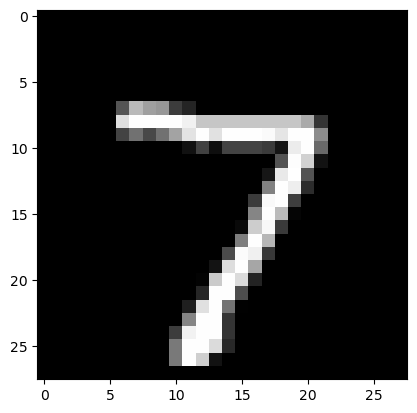

In [50]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy should be 97.6%

In [51]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


Have fun!

0- Original image (Label: 7), Adversarial image (Label: 9)


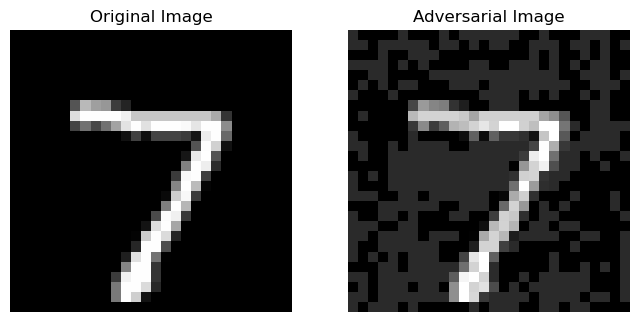

1- Original image (Label: 2), Adversarial image (Label: 8)


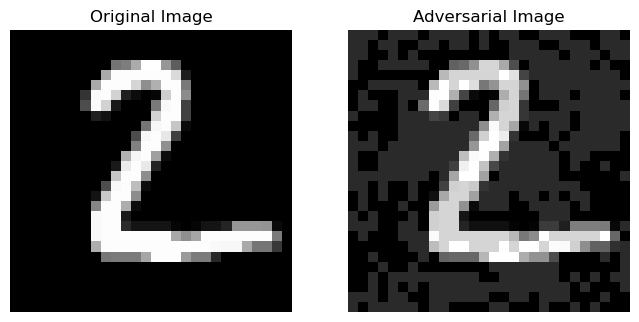

2- Original image (Label: 1), Adversarial image (Label: 7)


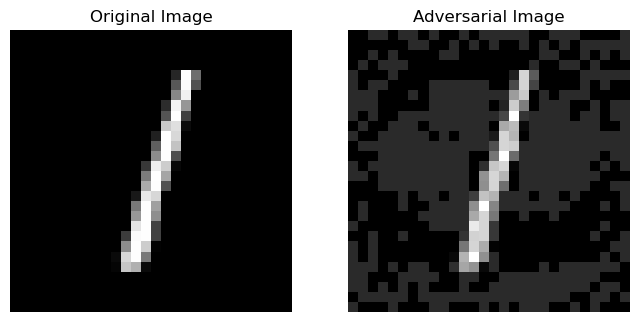

3- Original image (Label: 0), Adversarial image (Label: 7)


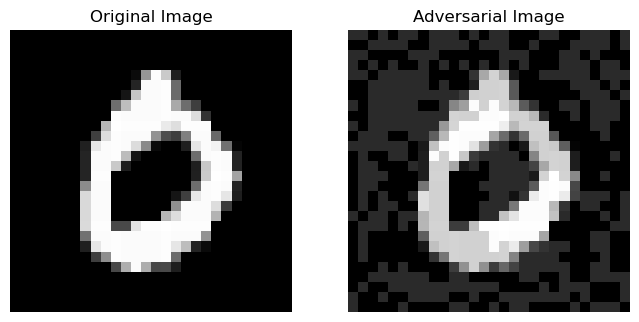

4- Original image (Label: 4), Adversarial image (Label: 9)


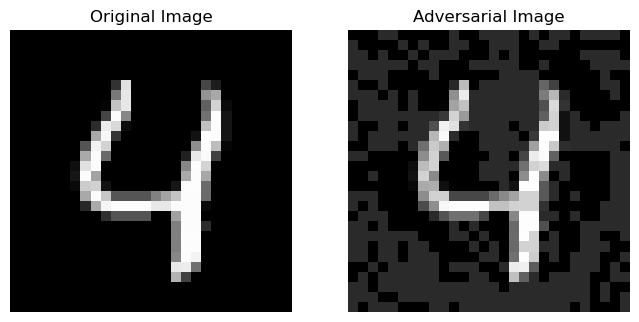

6- Original image (Label: 4), Adversarial image (Label: 8)


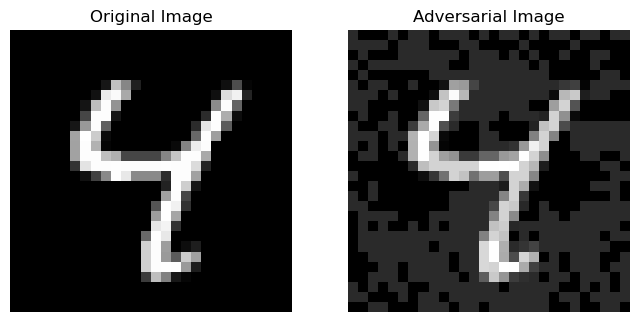

7- Original image (Label: 9), Adversarial image (Label: 3)


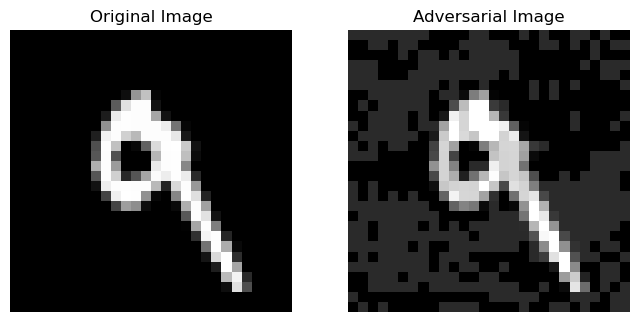

8- Original image (Label: 5), Adversarial image (Label: 6)


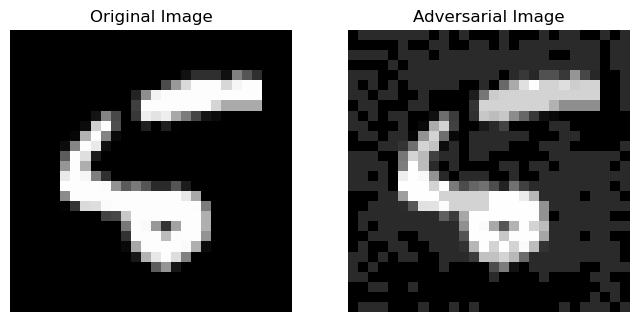

9- Original image (Label: 9), Adversarial image (Label: 4)


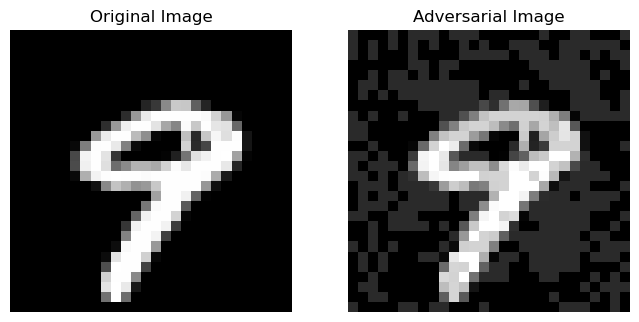

10- Original image (Label: 0), Adversarial image (Label: 5)


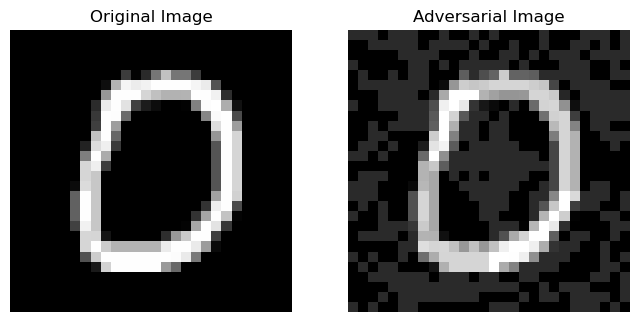

11- Original image (Label: 6), Adversarial image (Label: 8)


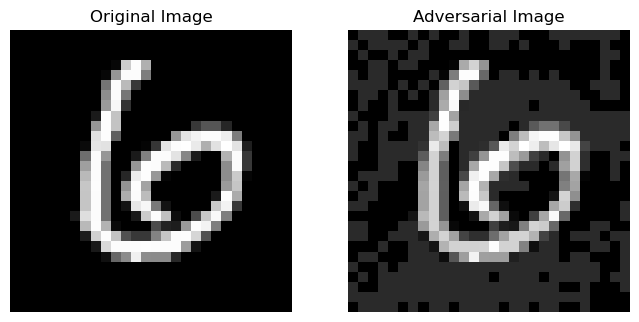

14- Original image (Label: 1), Adversarial image (Label: 8)


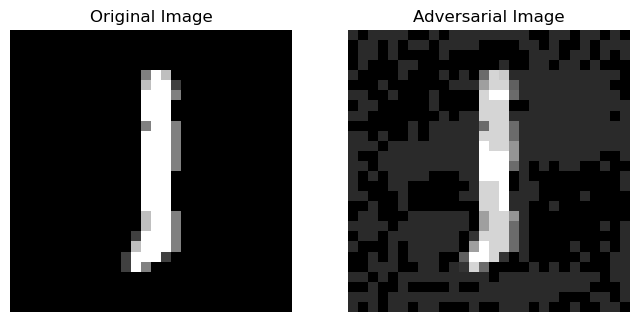

15- Original image (Label: 5), Adversarial image (Label: 3)


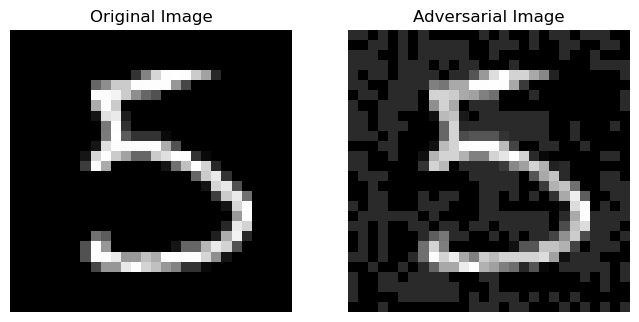

18- Original image (Label: 3), Adversarial image (Label: 8)


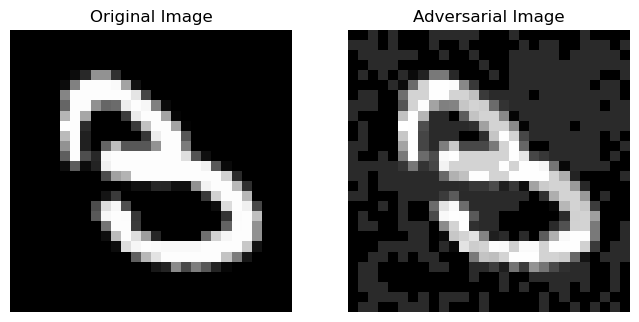

20- Original image (Label: 9), Adversarial image (Label: 7)


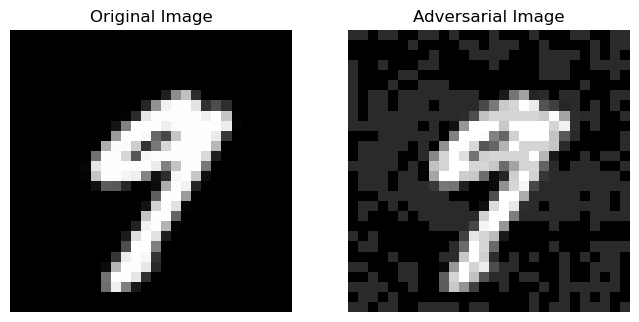

21- Original image (Label: 6), Adversarial image (Label: 5)


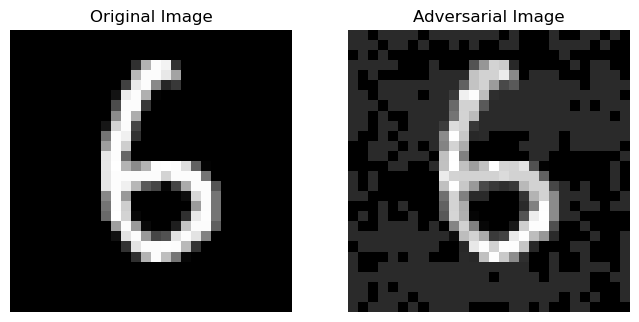

22- Original image (Label: 6), Adversarial image (Label: 4)


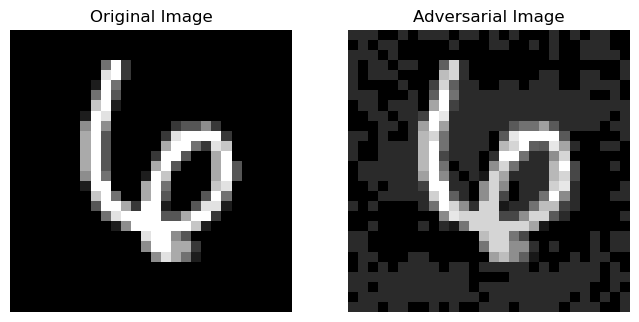

25- Original image (Label: 0), Adversarial image (Label: 6)


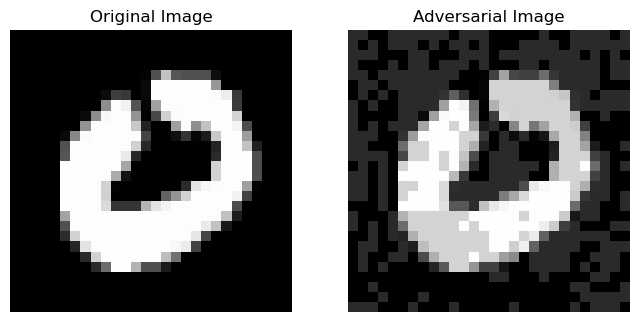

28- Original image (Label: 0), Adversarial image (Label: 2)


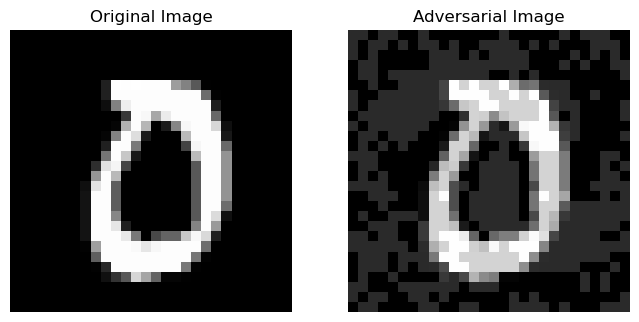

29- Original image (Label: 1), Adversarial image (Label: 5)


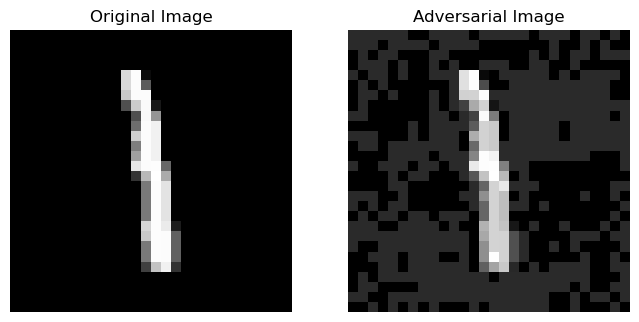

30- Original image (Label: 3), Adversarial image (Label: 9)


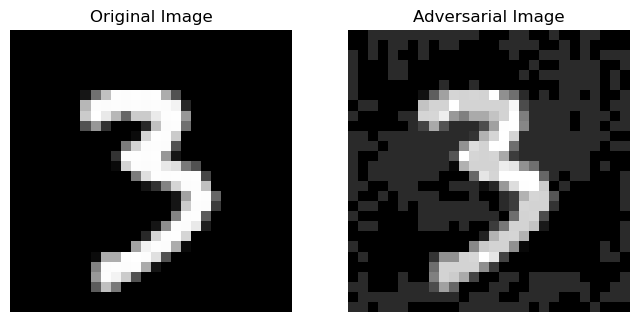

31- Original image (Label: 1), Adversarial image (Label: 9)


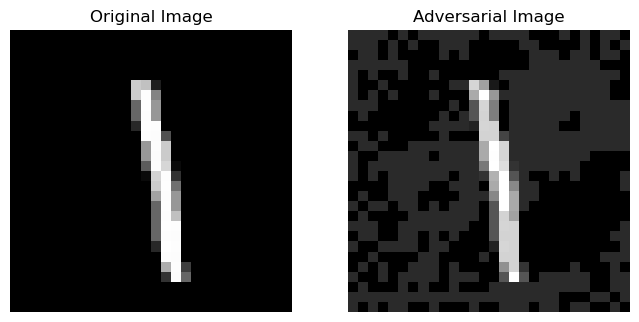

32- Original image (Label: 3), Adversarial image (Label: 5)


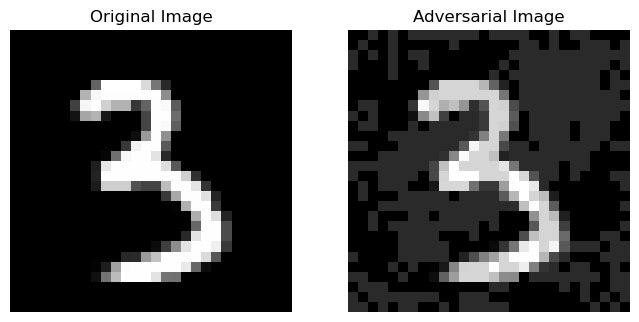

33- Original image (Label: 4), Adversarial image (Label: 0)


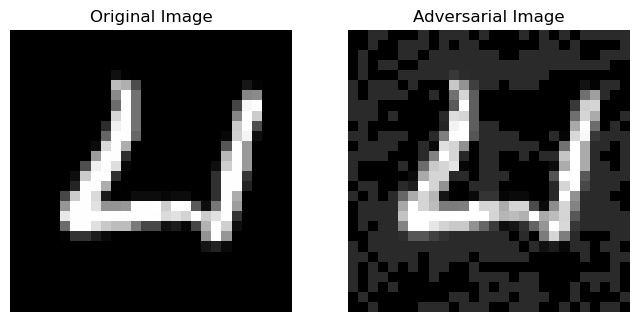

34- Original image (Label: 7), Adversarial image (Label: 3)


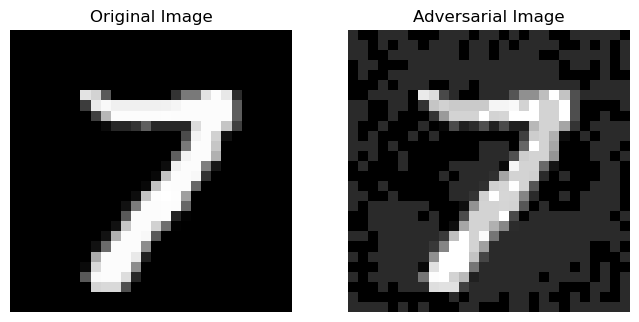

35- Original image (Label: 2), Adversarial image (Label: 3)


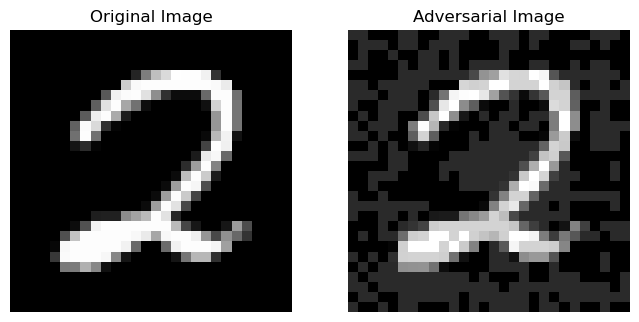

39- Original image (Label: 1), Adversarial image (Label: 4)


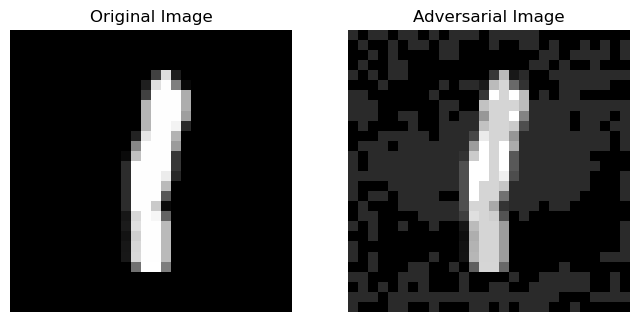

43- Original image (Label: 2), Adversarial image (Label: 6)


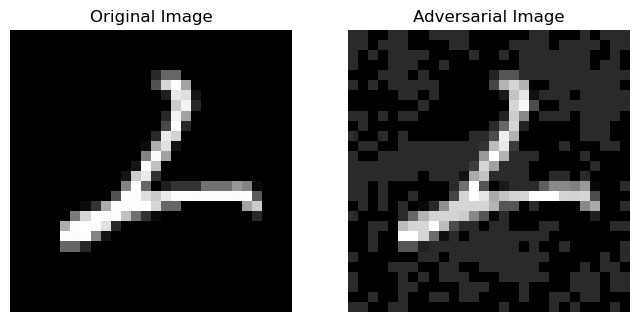

44- Original image (Label: 3), Adversarial image (Label: 6)


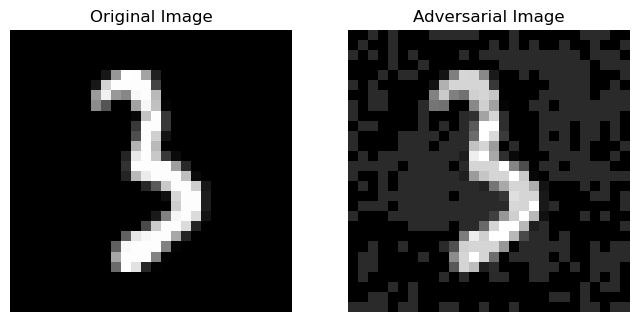

45- Original image (Label: 5), Adversarial image (Label: 8)


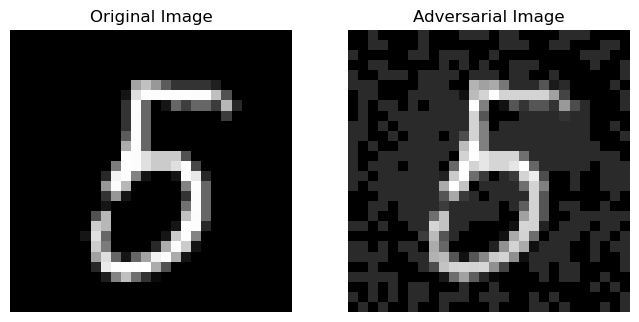

46- Original image (Label: 1), Adversarial image (Label: 3)


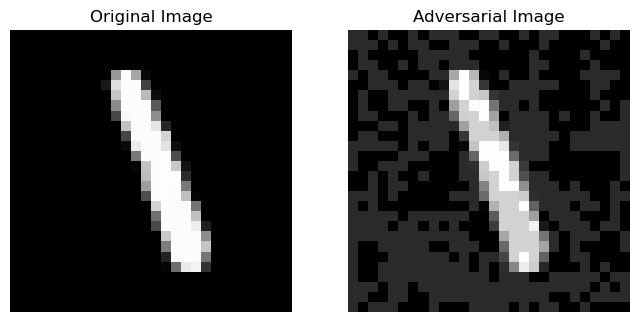

50- Original image (Label: 6), Adversarial image (Label: 0)


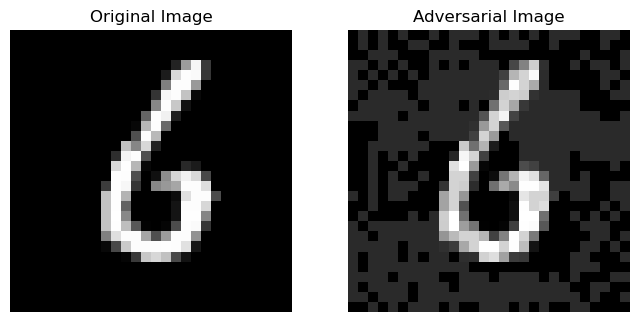

53- Original image (Label: 5), Adversarial image (Label: 9)


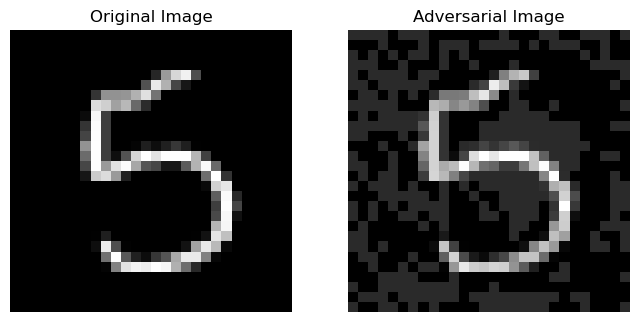

54- Original image (Label: 6), Adversarial image (Label: 6)


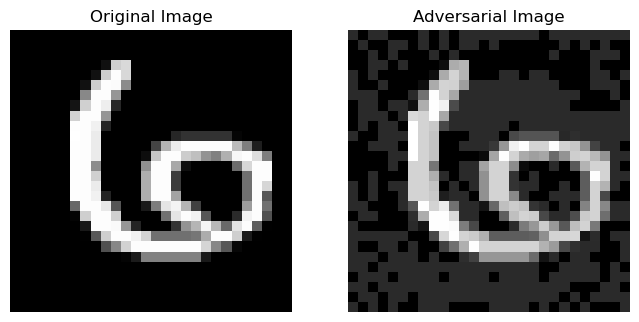

59- Original image (Label: 5), Adversarial image (Label: 7)


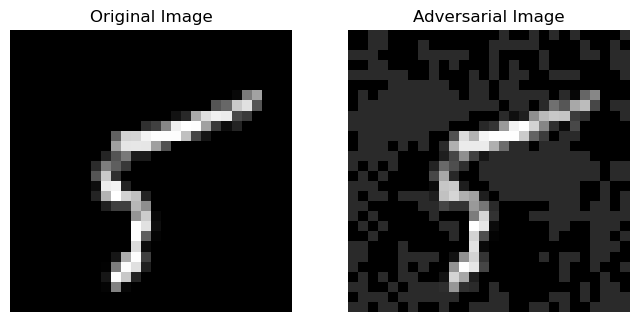

61- Original image (Label: 8), Adversarial image (Label: 9)


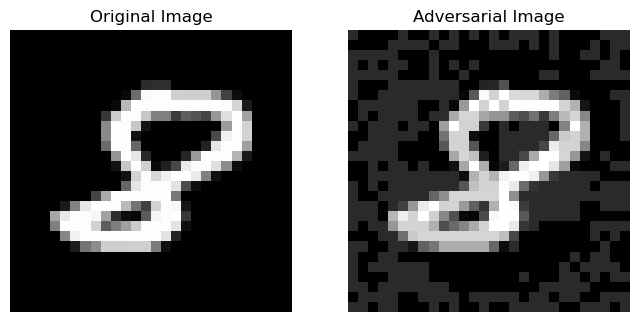

62- Original image (Label: 9), Adversarial image (Label: 5)


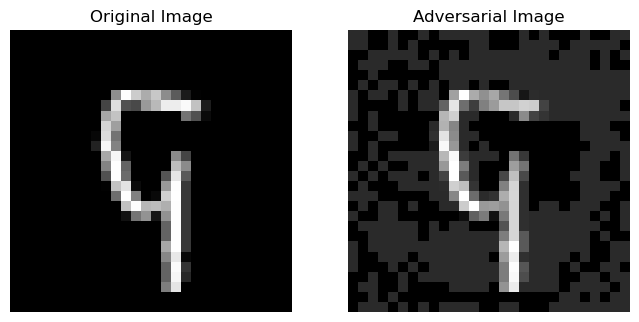

66- Original image (Label: 6), Adversarial image (Label: 7)


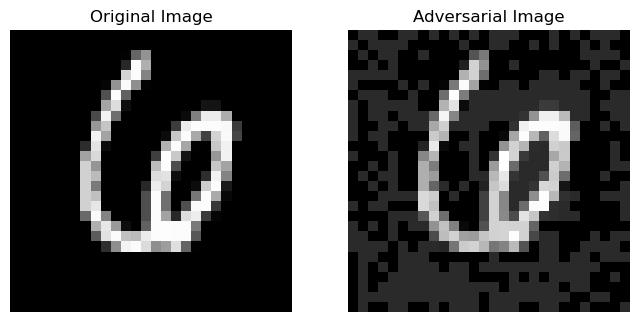

71- Original image (Label: 0), Adversarial image (Label: 0)


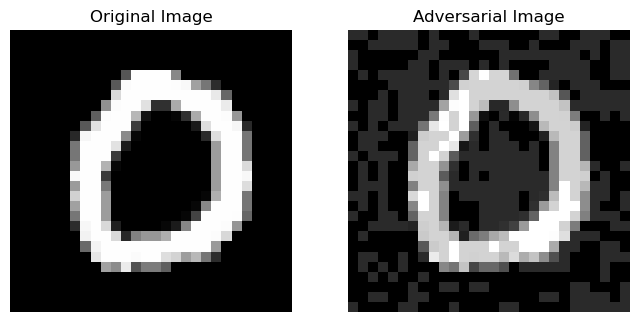

77- Original image (Label: 2), Adversarial image (Label: 9)


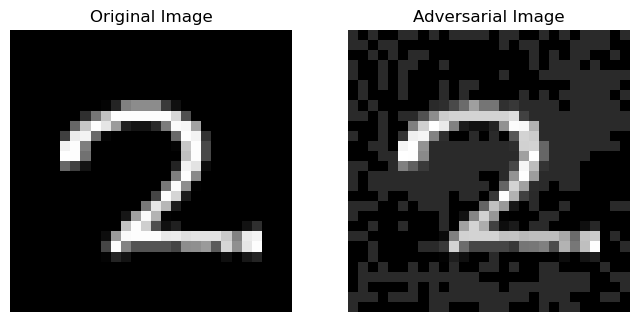

84- Original image (Label: 8), Adversarial image (Label: 5)


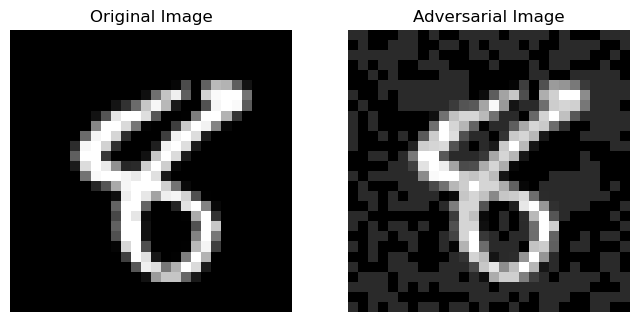

87- Original image (Label: 3), Adversarial image (Label: 7)


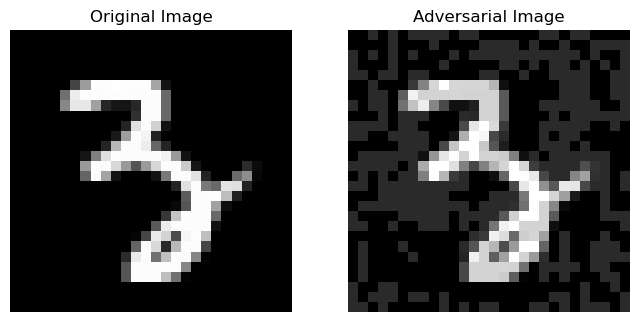

97- Original image (Label: 7), Adversarial image (Label: 1)


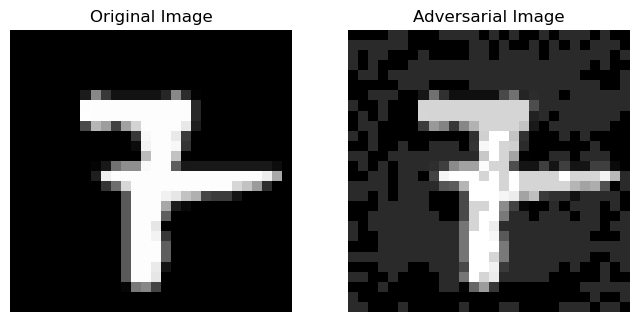

107- Original image (Label: 1), Adversarial image (Label: 6)


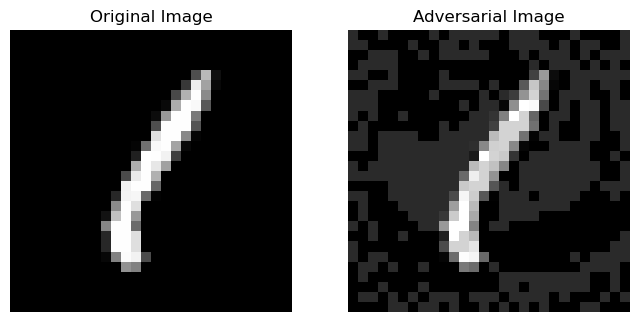

109- Original image (Label: 4), Adversarial image (Label: 7)


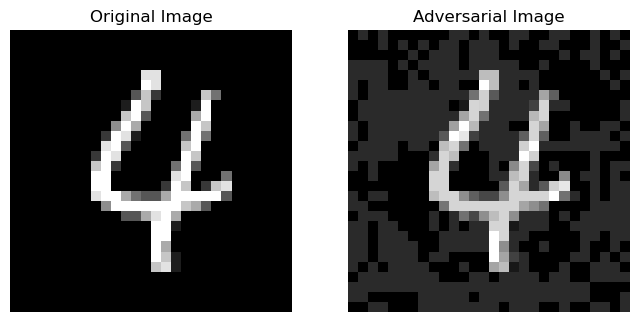

114- Original image (Label: 7), Adversarial image (Label: 2)


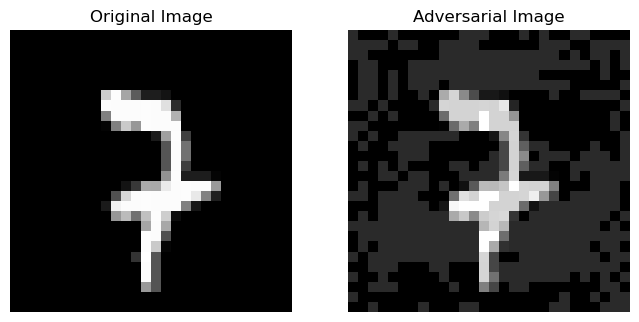

118- Original image (Label: 9), Adversarial image (Label: 6)


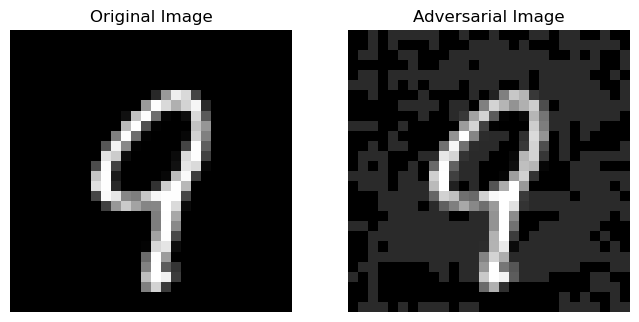

124- Original image (Label: 7), Adversarial image (Label: 4)


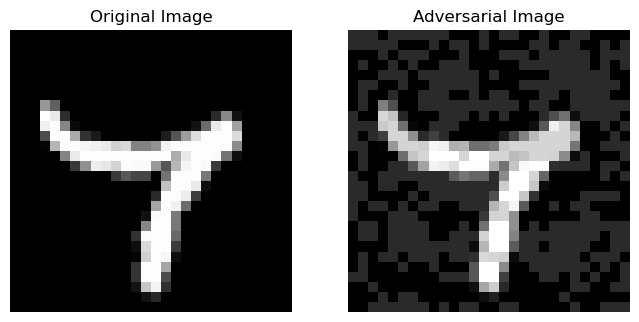

128- Original image (Label: 8), Adversarial image (Label: 3)


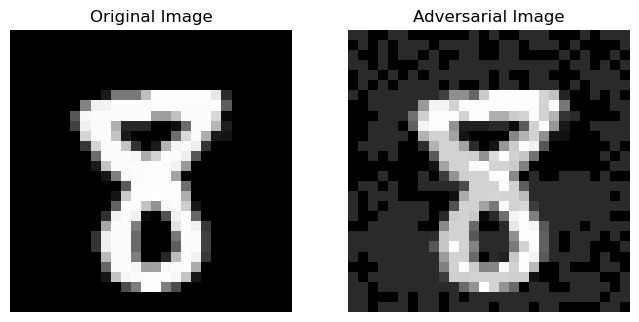

150- Original image (Label: 9), Adversarial image (Label: 8)


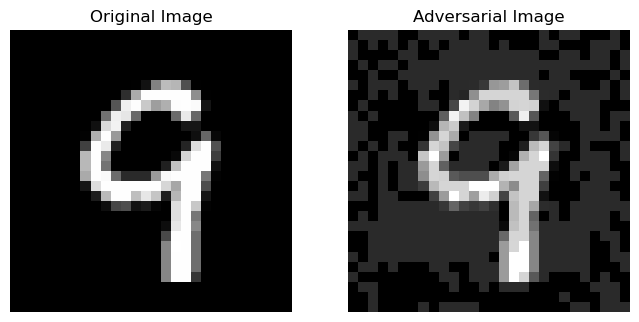

155- Original image (Label: 5), Adversarial image (Label: 4)


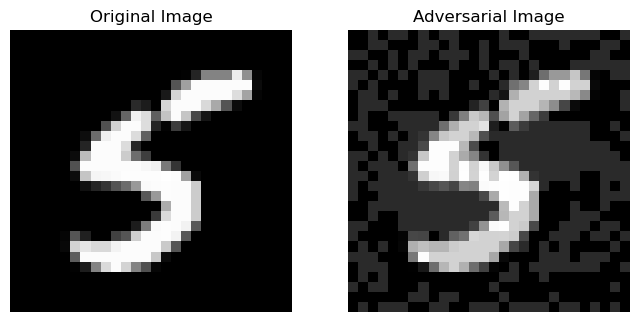

158- Original image (Label: 3), Adversarial image (Label: 2)


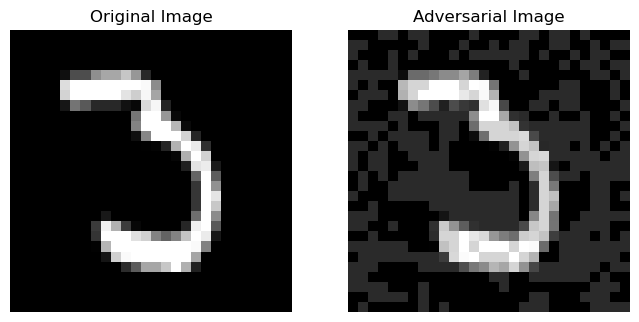

159- Original image (Label: 4), Adversarial image (Label: 1)


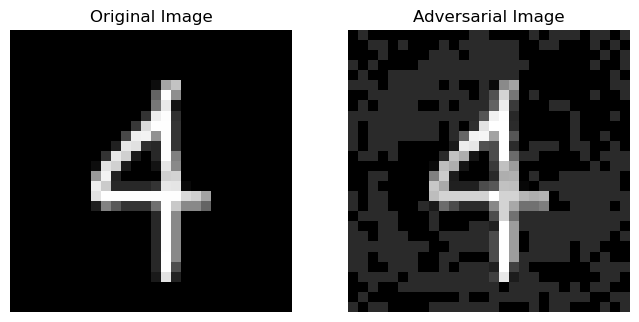

162- Original image (Label: 5), Adversarial image (Label: 5)


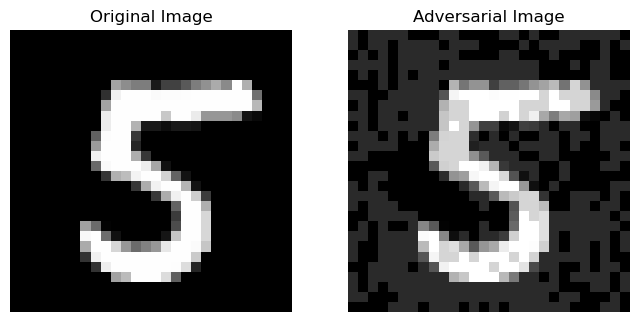

167- Original image (Label: 5), Adversarial image (Label: 2)


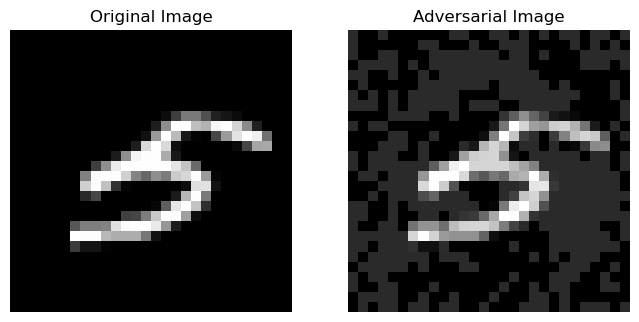

179- Original image (Label: 8), Adversarial image (Label: 2)


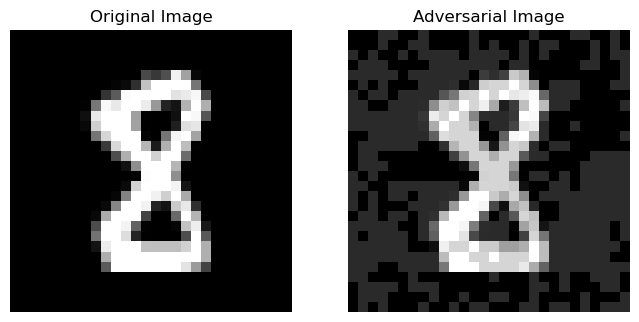

221- Original image (Label: 2), Adversarial image (Label: 0)


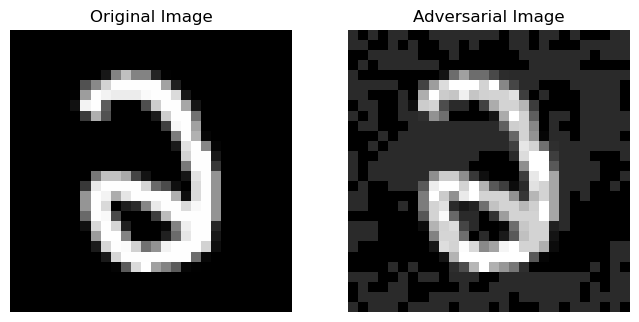

227- Original image (Label: 4), Adversarial image (Label: 3)


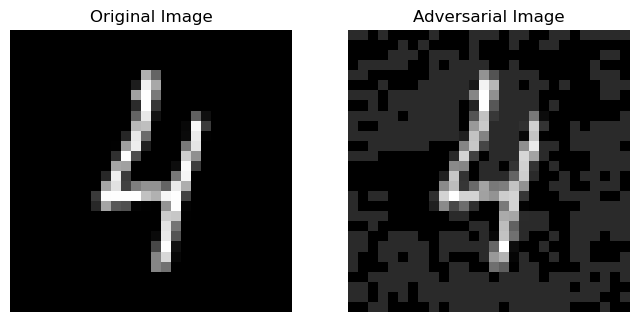

237- Original image (Label: 2), Adversarial image (Label: 1)


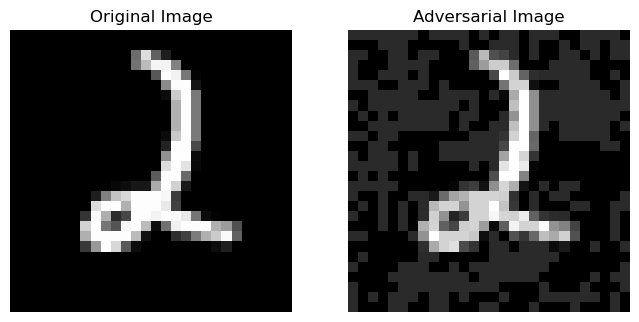

245- Original image (Label: 3), Adversarial image (Label: 1)


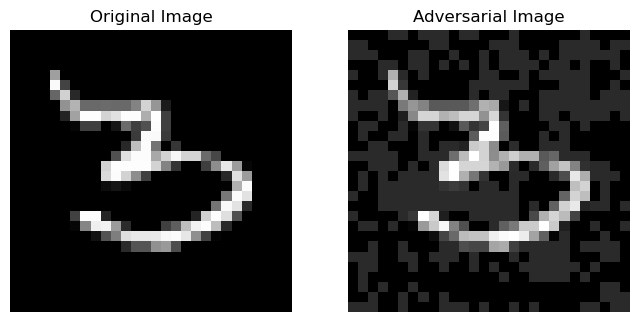

247- Original image (Label: 4), Adversarial image (Label: 2)


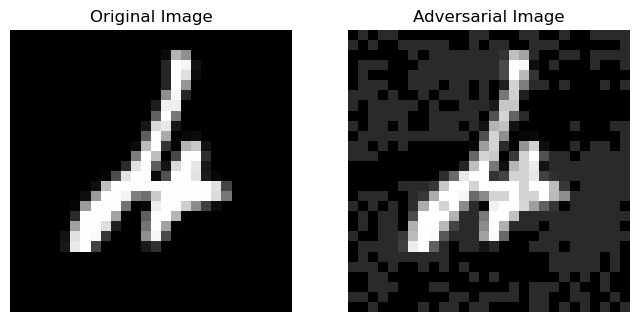

257- Original image (Label: 8), Adversarial image (Label: 1)


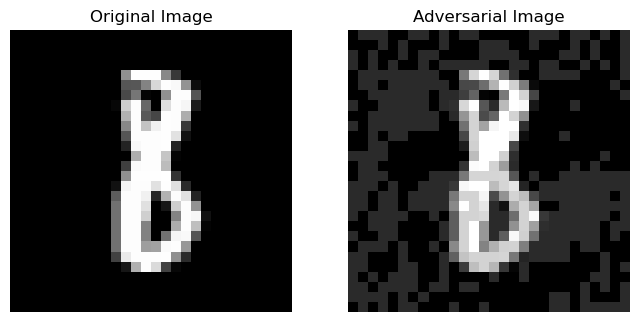

258- Original image (Label: 2), Adversarial image (Label: 2)


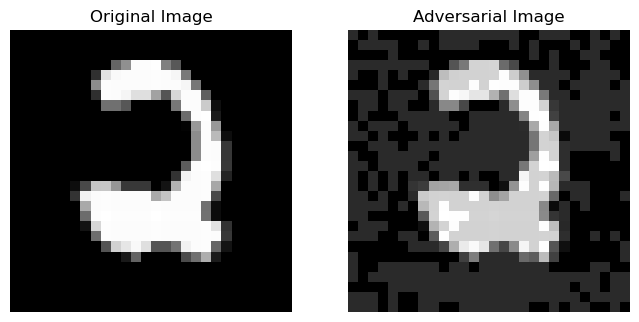

266- Original image (Label: 8), Adversarial image (Label: 0)


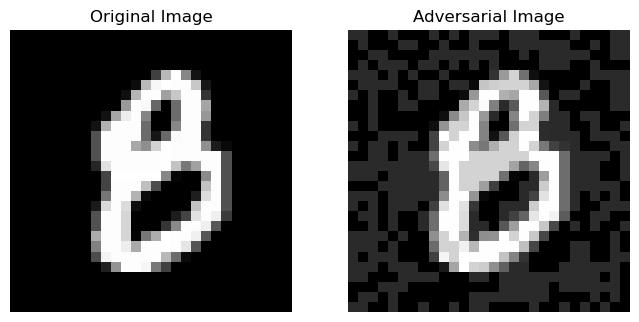

290- Original image (Label: 8), Adversarial image (Label: 4)


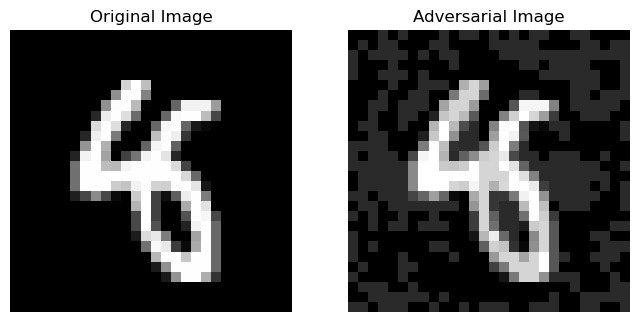

321- Original image (Label: 2), Adversarial image (Label: 7)


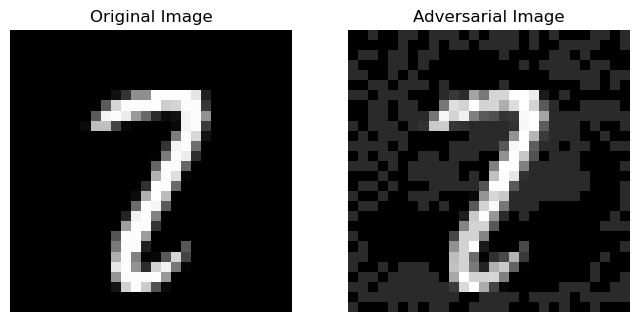

324- Original image (Label: 0), Adversarial image (Label: 4)


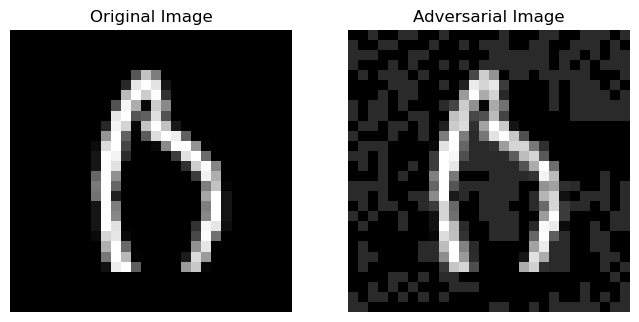

328- Original image (Label: 7), Adversarial image (Label: 8)


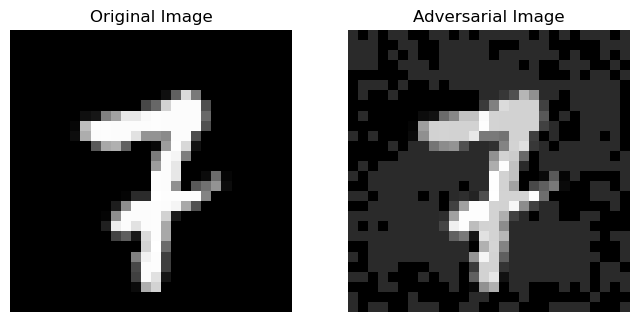

352- Original image (Label: 5), Adversarial image (Label: 0)


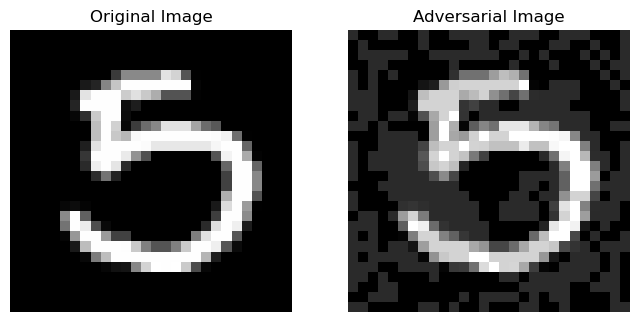

425- Original image (Label: 4), Adversarial image (Label: 6)


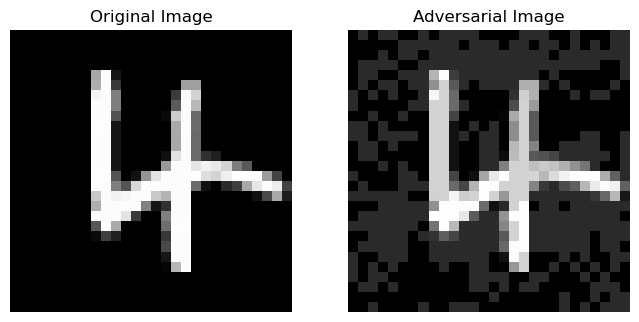

534- Original image (Label: 6), Adversarial image (Label: 2)


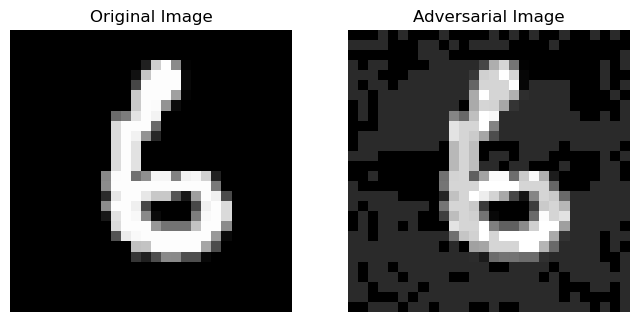

538- Original image (Label: 8), Adversarial image (Label: 6)


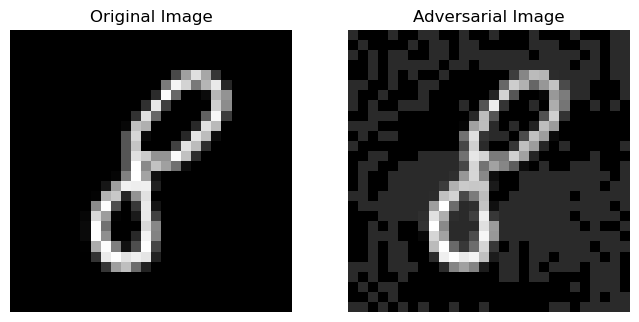

567- Original image (Label: 0), Adversarial image (Label: 3)


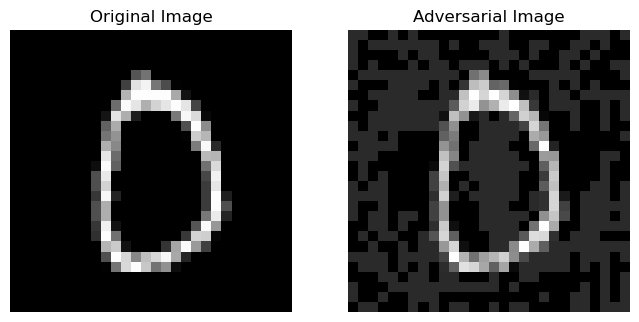

569- Original image (Label: 3), Adversarial image (Label: 4)


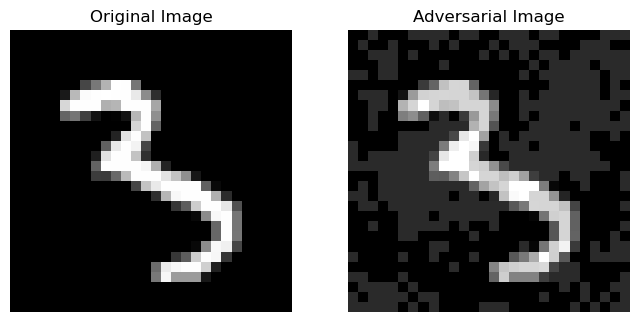

615- Original image (Label: 1), Adversarial image (Label: 2)


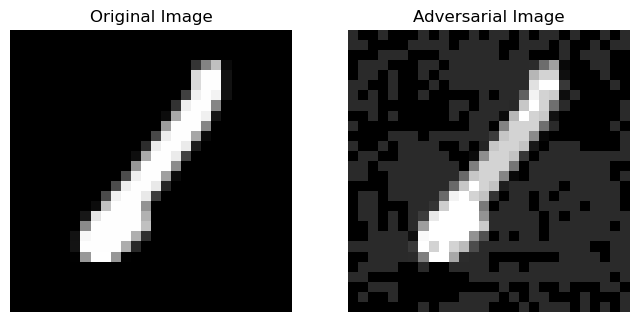

792- Original image (Label: 3), Adversarial image (Label: 3)


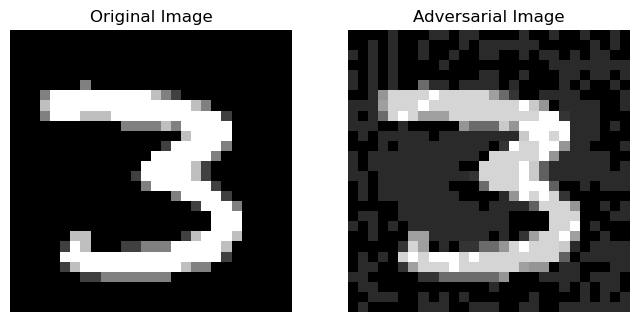

804- Original image (Label: 0), Adversarial image (Label: 9)


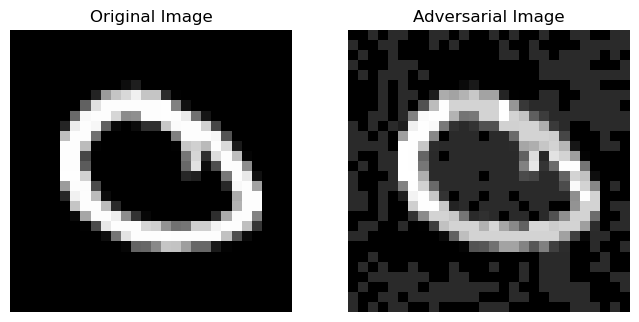

834- Original image (Label: 6), Adversarial image (Label: 1)


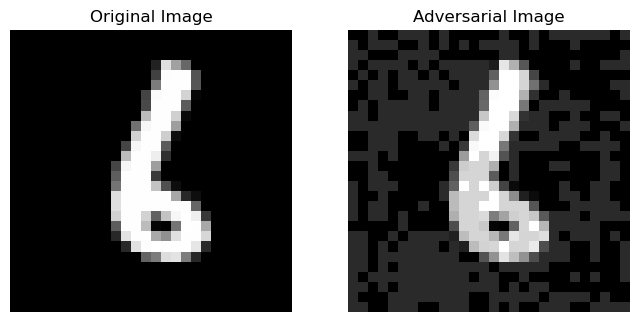

844- Original image (Label: 8), Adversarial image (Label: 7)


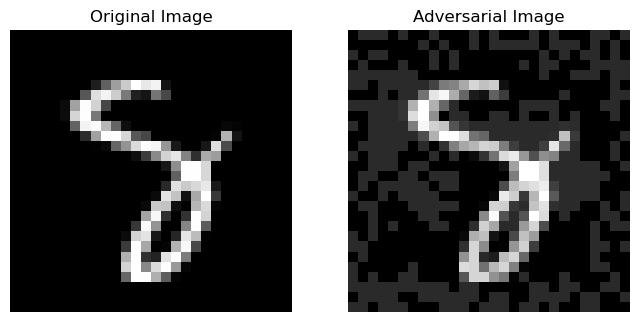

Accuracy on adversarial examples using FGSM: 0.014


In [62]:
def evaluate_on_adversarial_fgsm(clf, X_test, Y_test, nTest, eps):
    clf.set_attack_budget(eps)
    correct = 0
    encountered_labels = set()  # Keep track of encountered label pairs
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x_adv = clf.fgsm_attack(x, y)  # Perform FGSM attack
        y_pred = clf.predict(x_adv)
        if y_pred == y:
            correct += 1

        # Check if the label pair has been encountered before
        label_pair = (y, y_pred)
        if label_pair not in encountered_labels:
            # Print original and adversarial images
            print(f"{i}- Original image (Label: {y}), Adversarial image (Label: {y_pred})")
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(x_adv.reshape(28, 28), cmap='gray')
            plt.title('Adversarial Image')
            plt.axis('off')

            plt.show()

            # Mark the label pair as encountered
            encountered_labels.add(label_pair)

    acc = correct / nTest
    return acc

# Set the number of test examples and epsilon
nTest = len(Y_test)  # Or a smaller number if you want to test on a subset
epsilon = 0.1

# Evaluate the accuracy on adversarial examples using FGSM
acc_adv_fgsm = evaluate_on_adversarial_fgsm(clf, X_test, Y_test, nTest, epsilon)
print(f"Accuracy on adversarial examples using FGSM: {acc_adv_fgsm}")

0- Original image (Label: 7), Adversarial image (Label: 9)


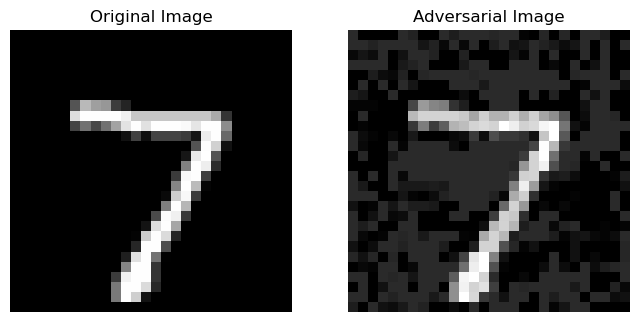

1- Original image (Label: 2), Adversarial image (Label: 8)


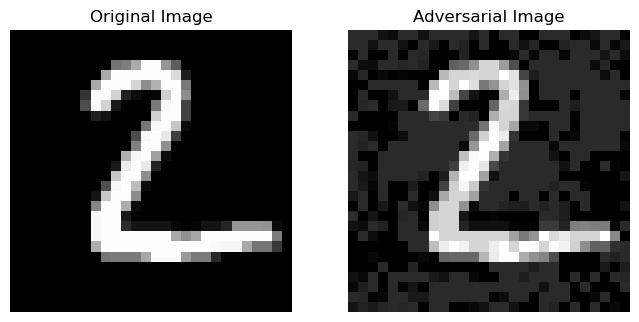

2- Original image (Label: 1), Adversarial image (Label: 7)


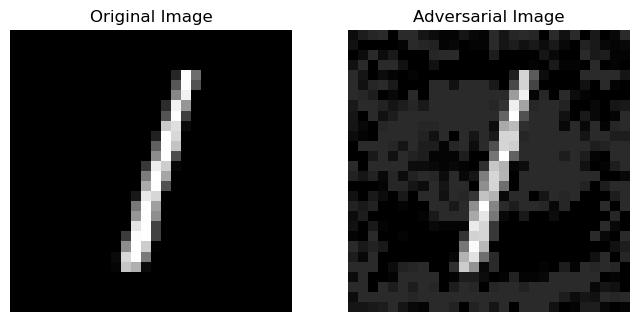

3- Original image (Label: 0), Adversarial image (Label: 7)


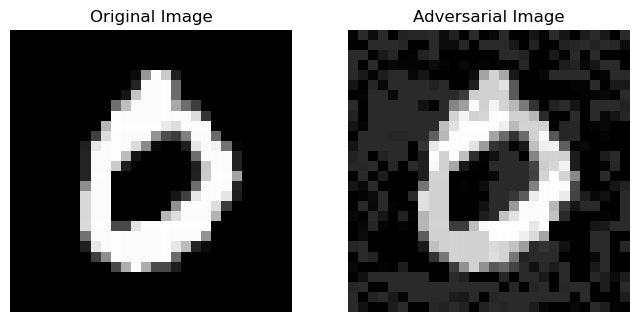

4- Original image (Label: 4), Adversarial image (Label: 9)


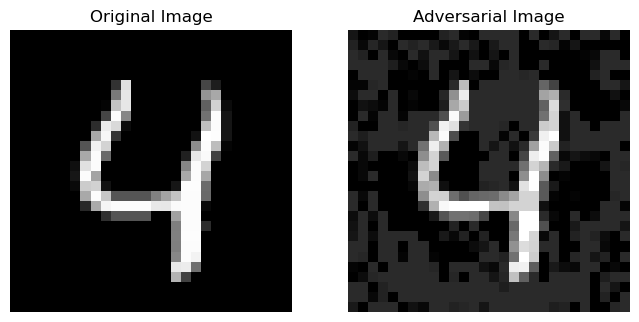

6- Original image (Label: 4), Adversarial image (Label: 8)


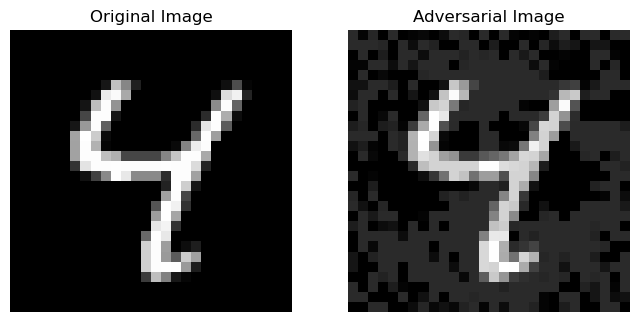

7- Original image (Label: 9), Adversarial image (Label: 3)


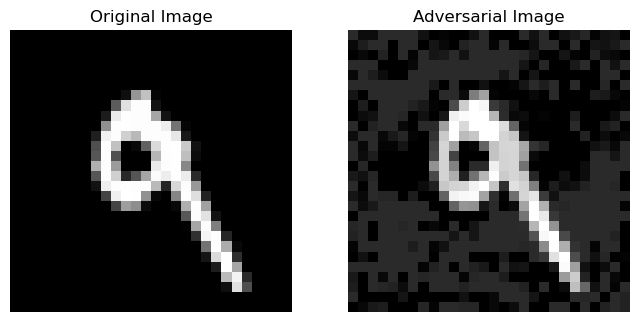

8- Original image (Label: 5), Adversarial image (Label: 6)


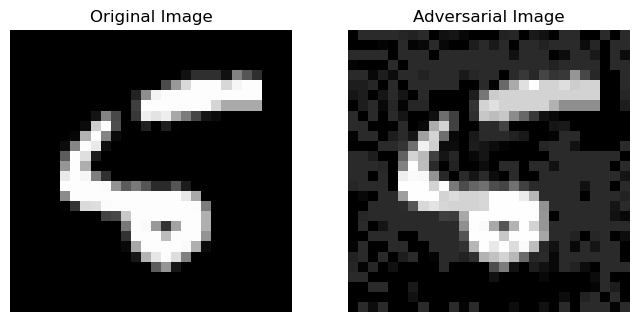

9- Original image (Label: 9), Adversarial image (Label: 4)


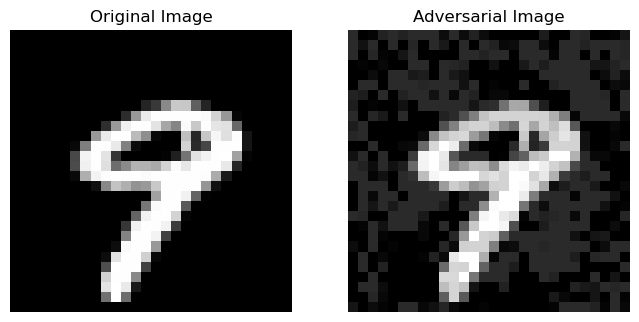

10- Original image (Label: 0), Adversarial image (Label: 5)


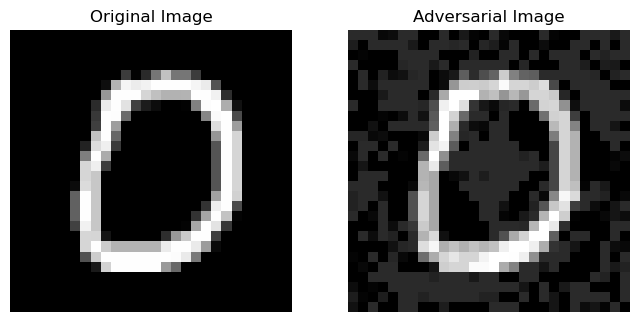

11- Original image (Label: 6), Adversarial image (Label: 8)


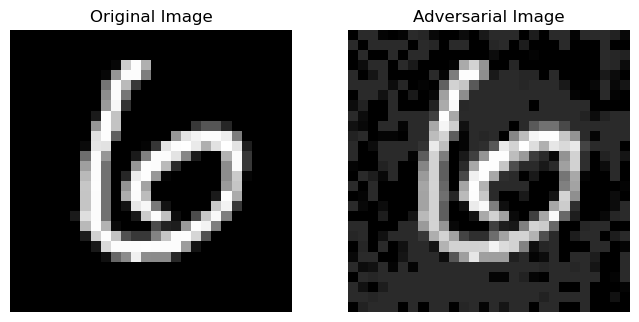

14- Original image (Label: 1), Adversarial image (Label: 8)


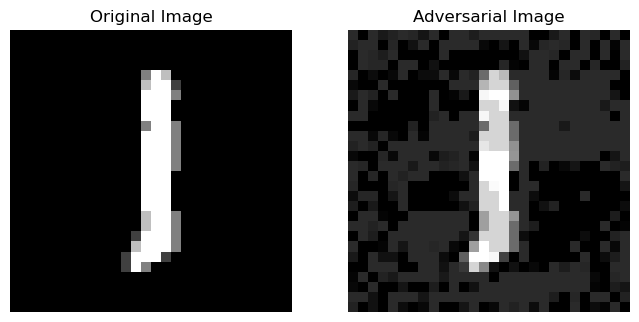

15- Original image (Label: 5), Adversarial image (Label: 3)


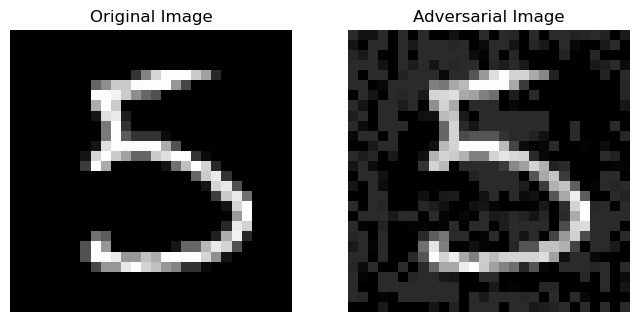

18- Original image (Label: 3), Adversarial image (Label: 8)


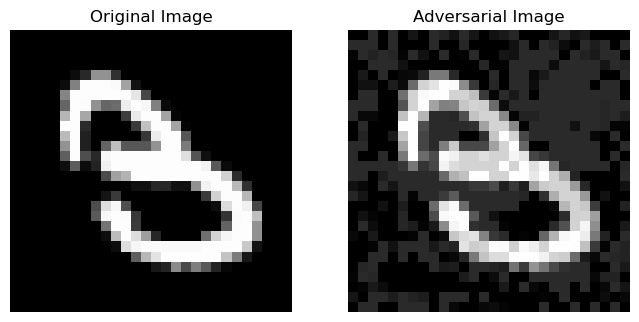

20- Original image (Label: 9), Adversarial image (Label: 7)


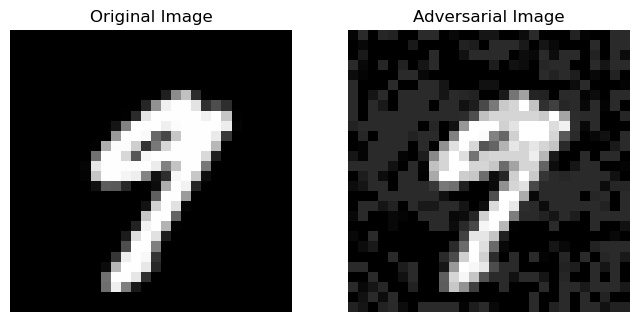

21- Original image (Label: 6), Adversarial image (Label: 5)


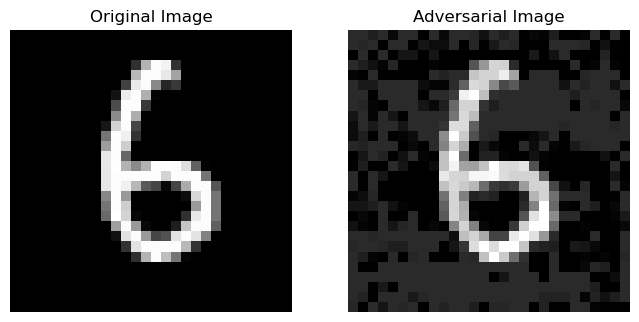

22- Original image (Label: 6), Adversarial image (Label: 4)


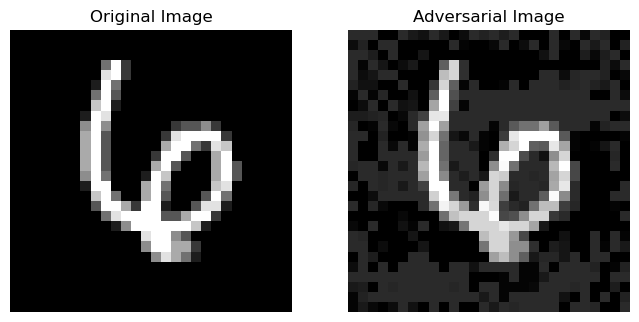

25- Original image (Label: 0), Adversarial image (Label: 6)


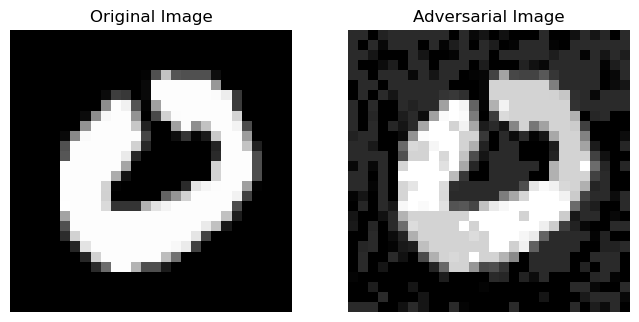

28- Original image (Label: 0), Adversarial image (Label: 2)


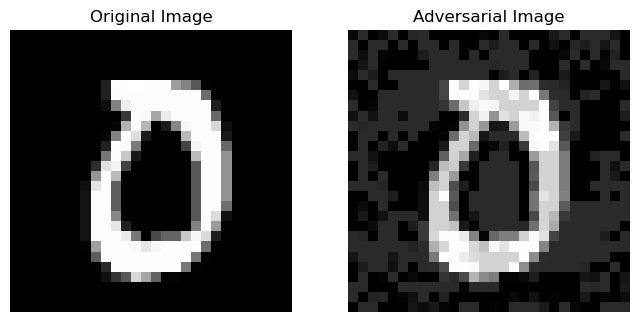

30- Original image (Label: 3), Adversarial image (Label: 9)


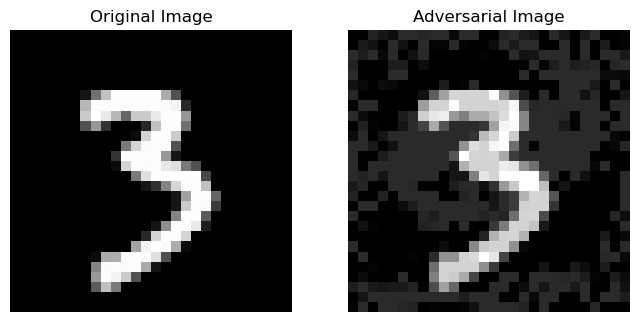

31- Original image (Label: 1), Adversarial image (Label: 4)


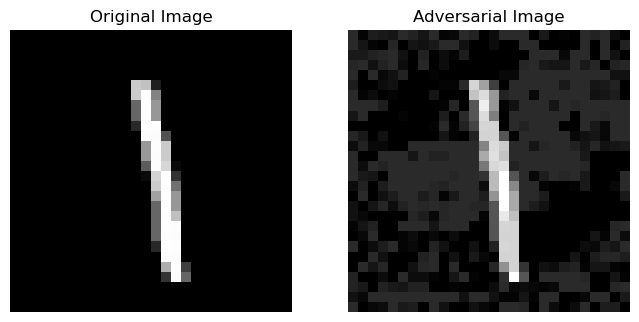

32- Original image (Label: 3), Adversarial image (Label: 5)


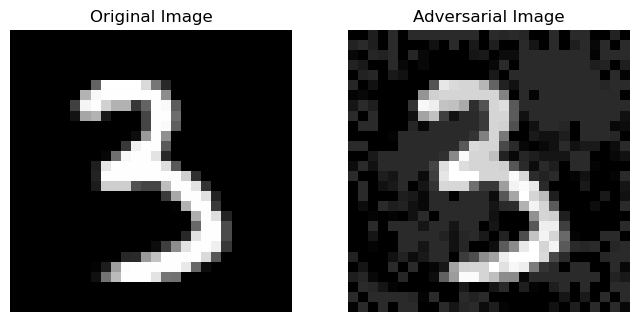

33- Original image (Label: 4), Adversarial image (Label: 0)


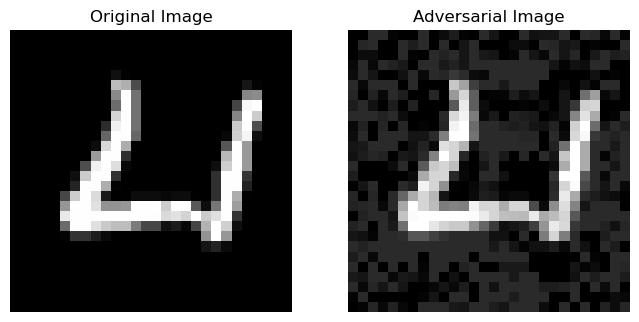

34- Original image (Label: 7), Adversarial image (Label: 3)


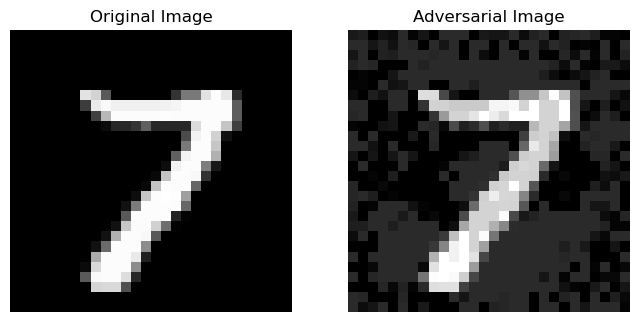

35- Original image (Label: 2), Adversarial image (Label: 3)


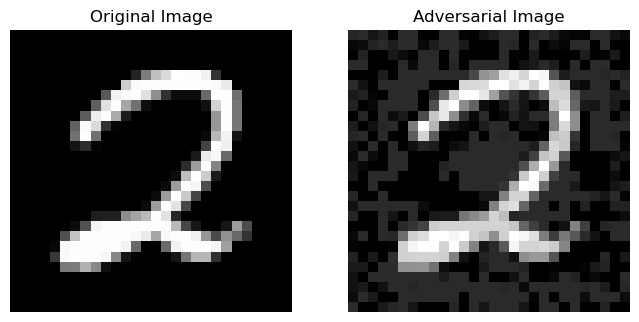

43- Original image (Label: 2), Adversarial image (Label: 6)


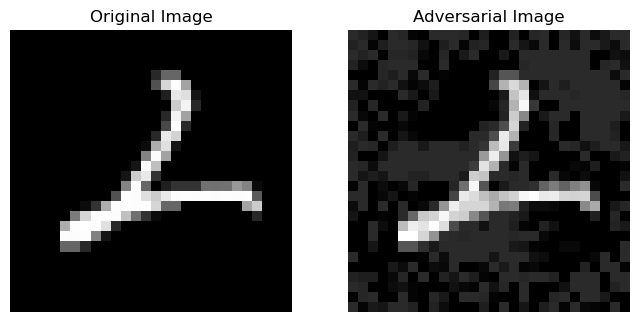

44- Original image (Label: 3), Adversarial image (Label: 1)


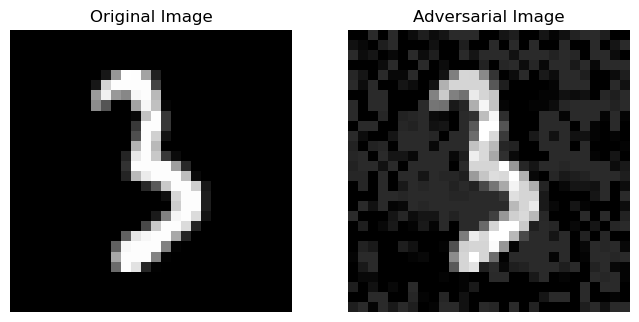

45- Original image (Label: 5), Adversarial image (Label: 8)


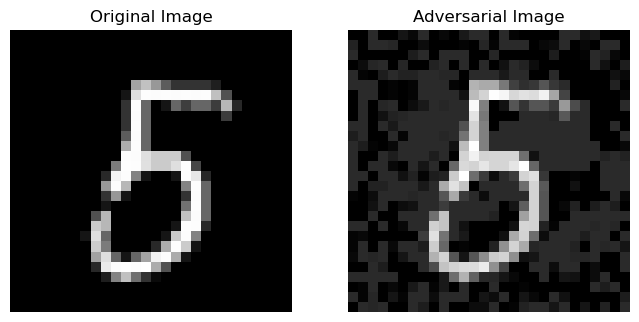

46- Original image (Label: 1), Adversarial image (Label: 3)


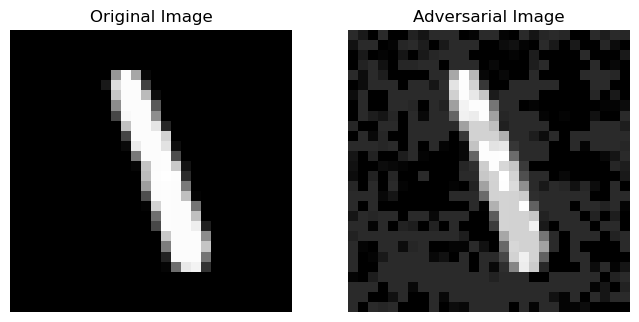

50- Original image (Label: 6), Adversarial image (Label: 0)


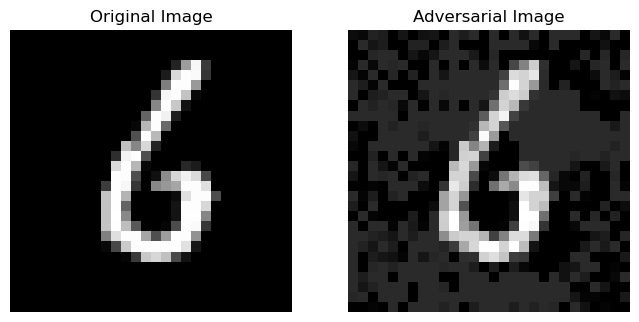

53- Original image (Label: 5), Adversarial image (Label: 9)


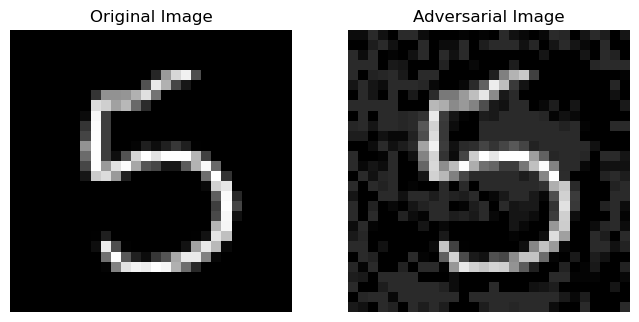

54- Original image (Label: 6), Adversarial image (Label: 6)


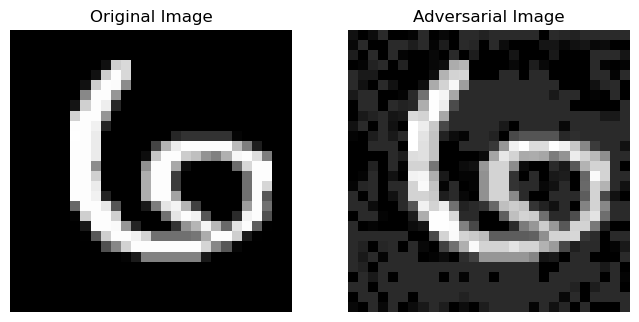

59- Original image (Label: 5), Adversarial image (Label: 7)


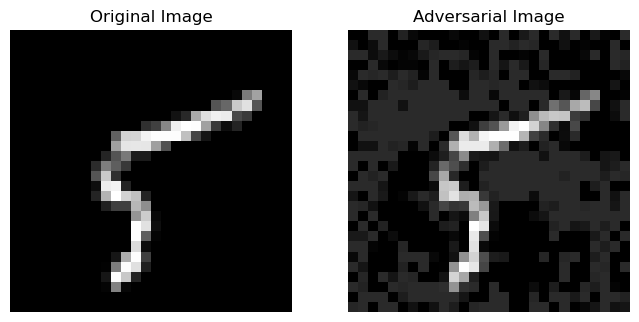

61- Original image (Label: 8), Adversarial image (Label: 9)


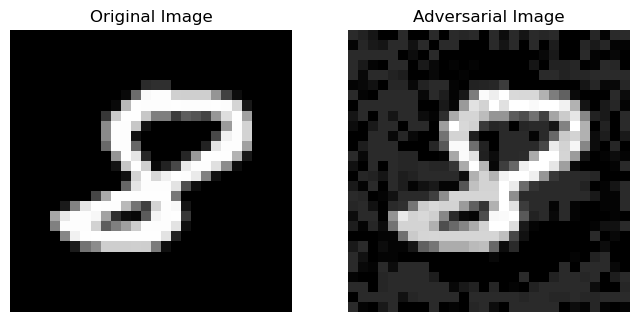

62- Original image (Label: 9), Adversarial image (Label: 5)


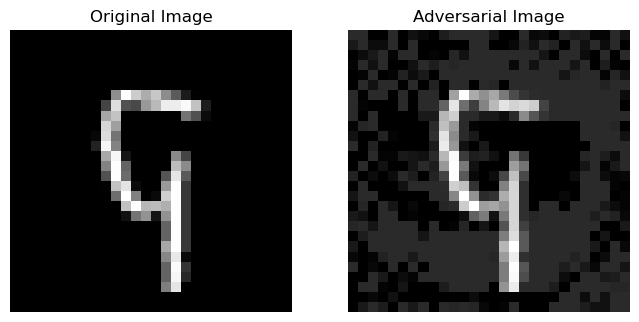

71- Original image (Label: 0), Adversarial image (Label: 0)


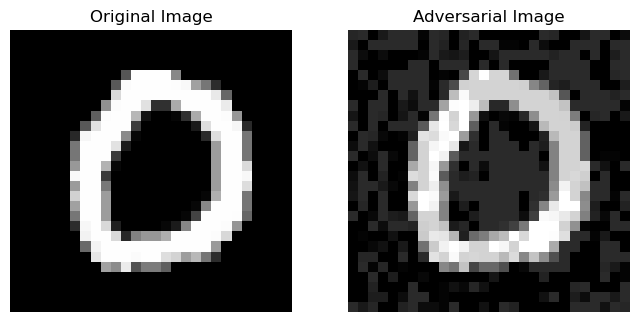

84- Original image (Label: 8), Adversarial image (Label: 5)


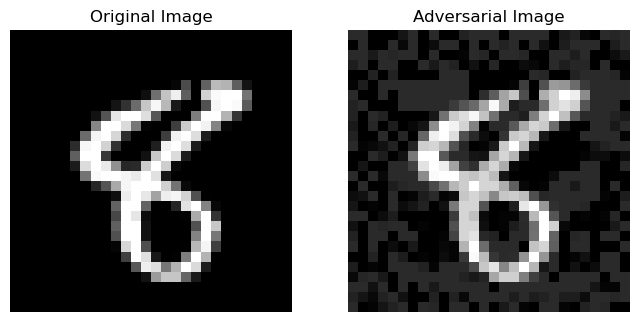

87- Original image (Label: 3), Adversarial image (Label: 7)


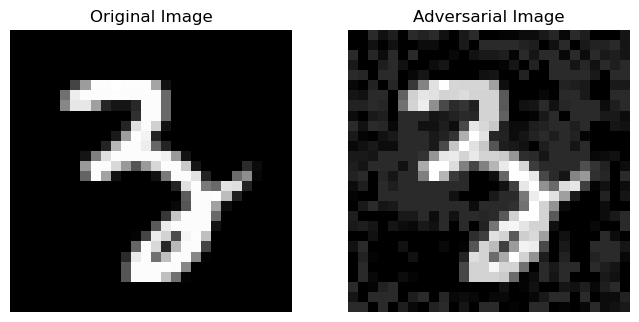

96- Original image (Label: 1), Adversarial image (Label: 9)


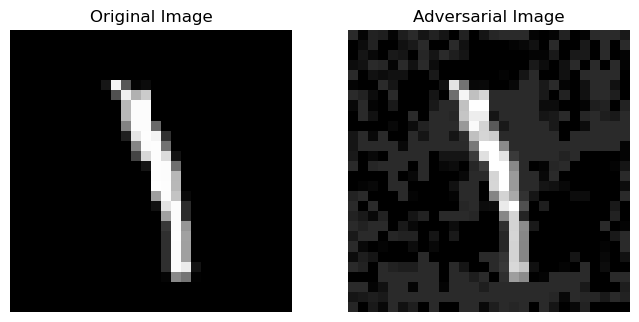

97- Original image (Label: 7), Adversarial image (Label: 1)


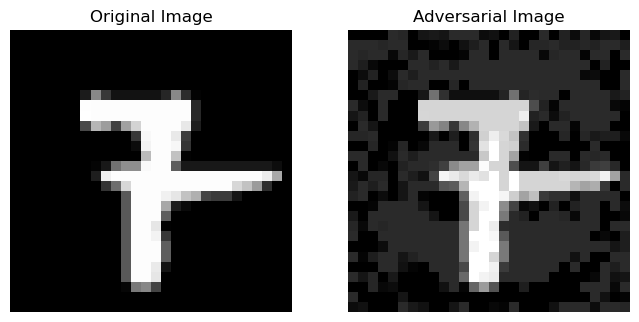

107- Original image (Label: 1), Adversarial image (Label: 6)


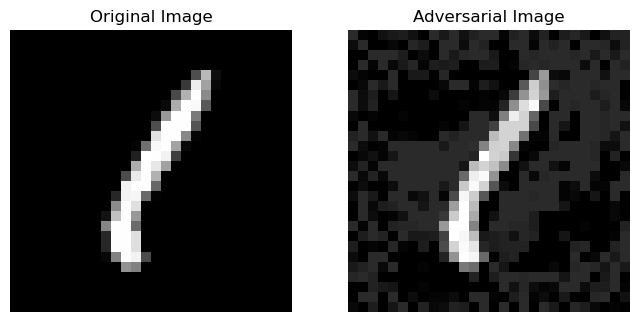

109- Original image (Label: 4), Adversarial image (Label: 7)


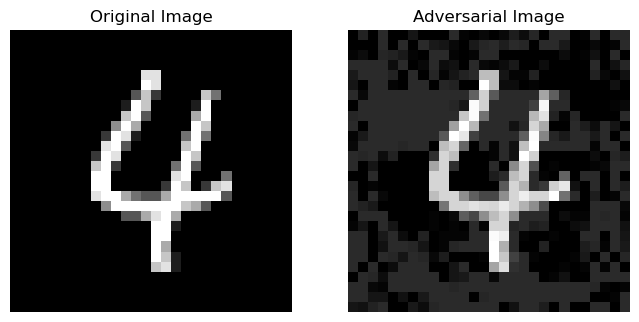

114- Original image (Label: 7), Adversarial image (Label: 2)


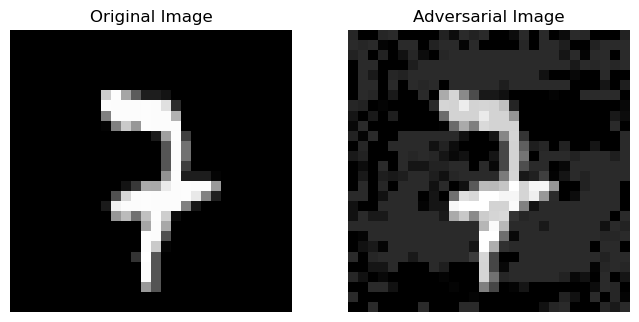

124- Original image (Label: 7), Adversarial image (Label: 4)


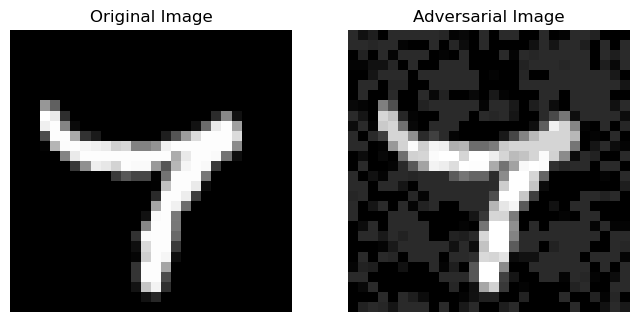

128- Original image (Label: 8), Adversarial image (Label: 3)


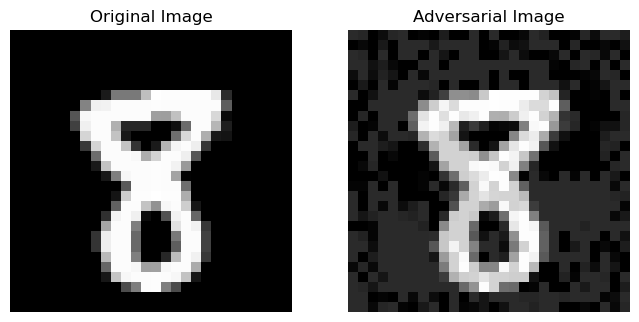

149- Original image (Label: 2), Adversarial image (Label: 9)


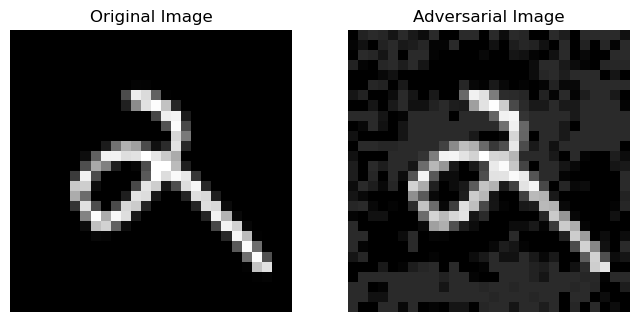

150- Original image (Label: 9), Adversarial image (Label: 8)


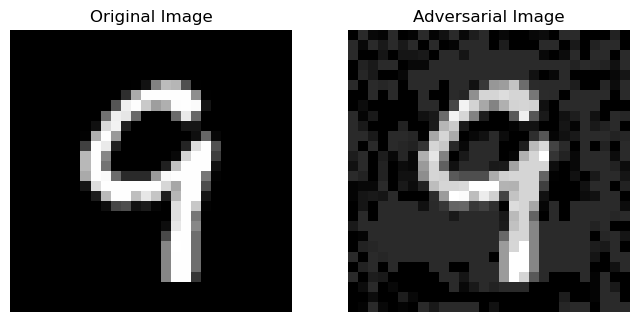

158- Original image (Label: 3), Adversarial image (Label: 2)


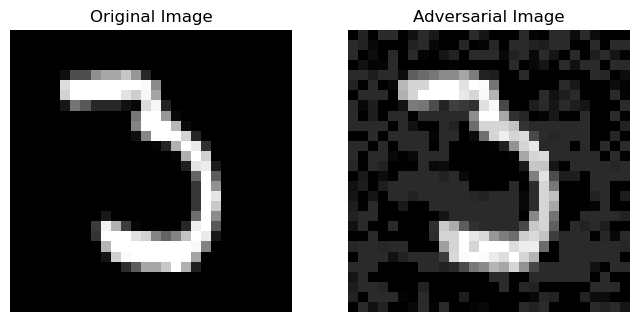

159- Original image (Label: 4), Adversarial image (Label: 1)


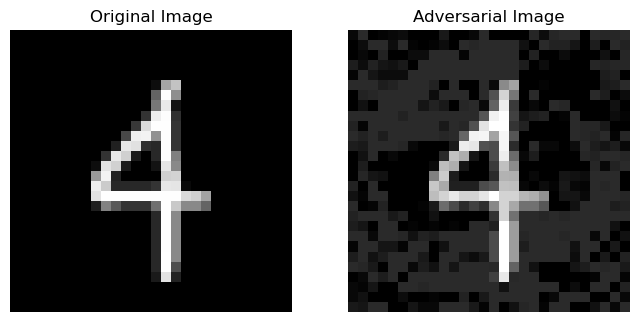

162- Original image (Label: 5), Adversarial image (Label: 5)


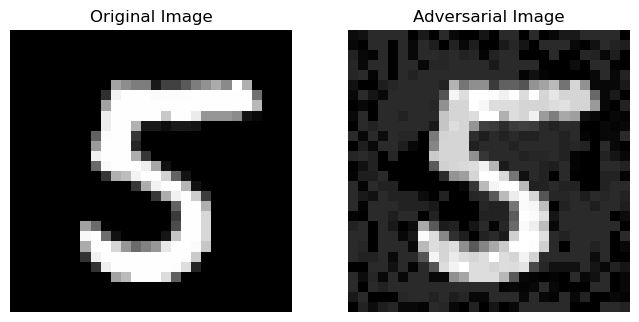

167- Original image (Label: 5), Adversarial image (Label: 0)


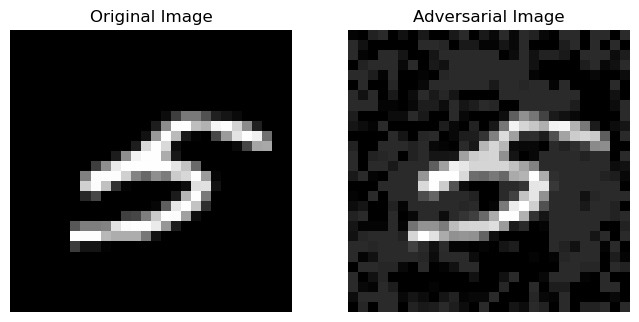

179- Original image (Label: 8), Adversarial image (Label: 2)


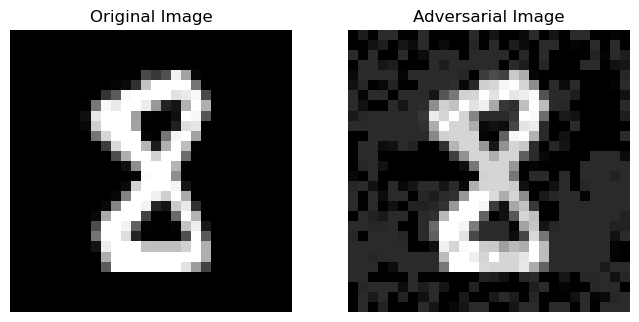

203- Original image (Label: 1), Adversarial image (Label: 5)


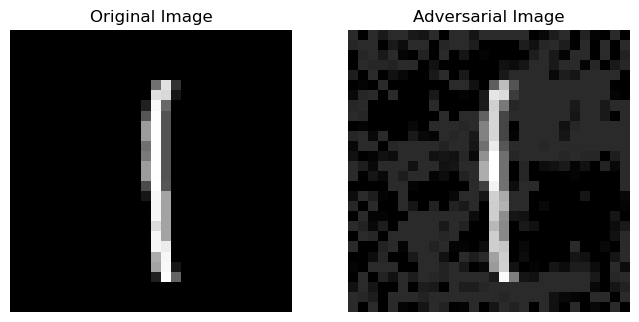

221- Original image (Label: 2), Adversarial image (Label: 0)


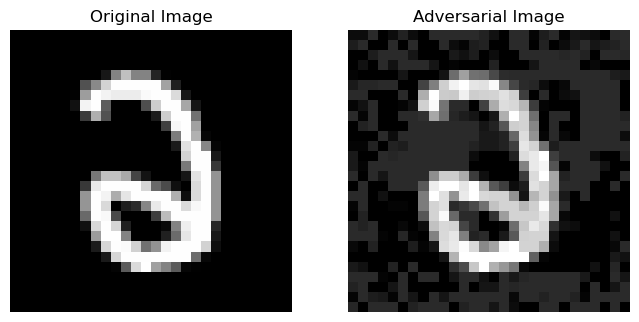

227- Original image (Label: 4), Adversarial image (Label: 3)


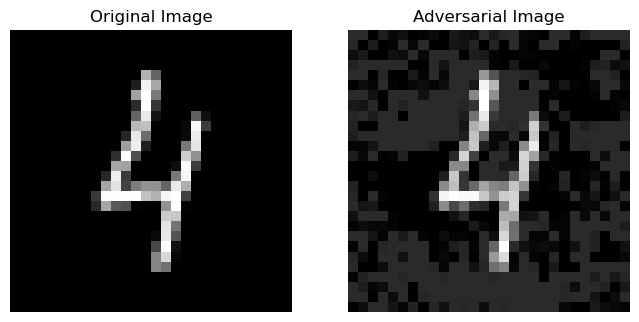

237- Original image (Label: 2), Adversarial image (Label: 1)


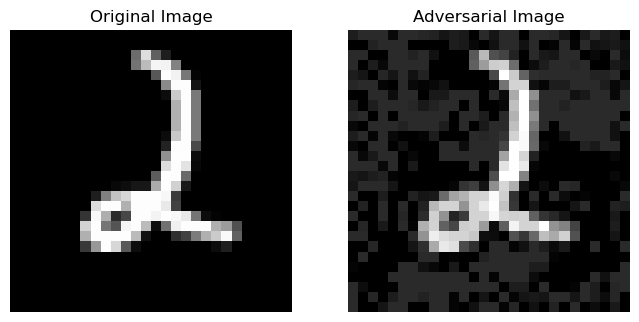

247- Original image (Label: 4), Adversarial image (Label: 2)


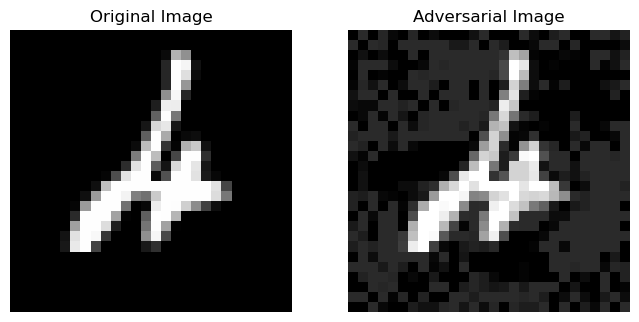

257- Original image (Label: 8), Adversarial image (Label: 1)


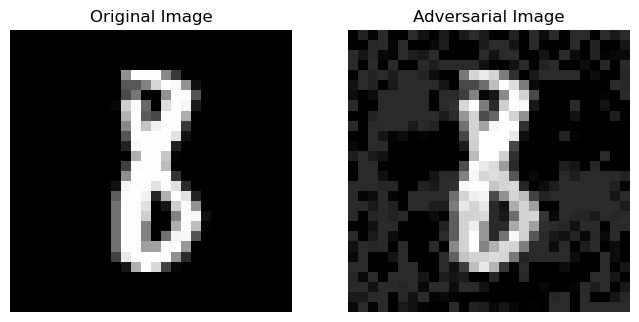

266- Original image (Label: 8), Adversarial image (Label: 0)


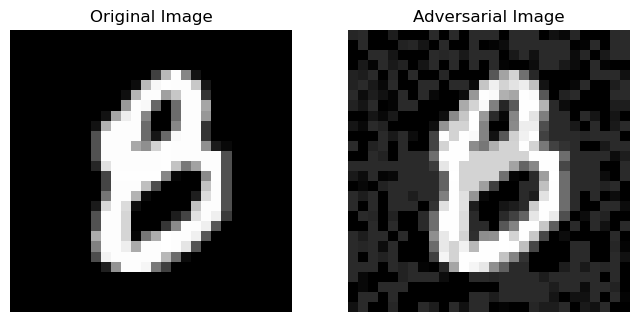

290- Original image (Label: 8), Adversarial image (Label: 4)


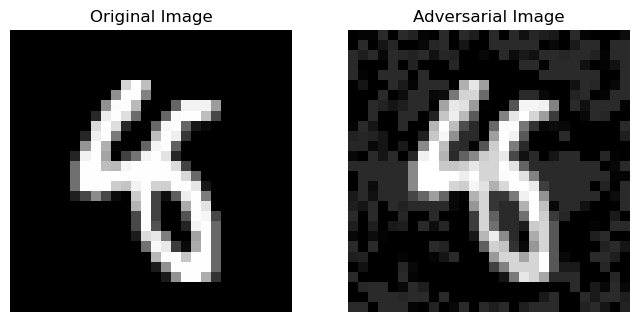

321- Original image (Label: 2), Adversarial image (Label: 7)


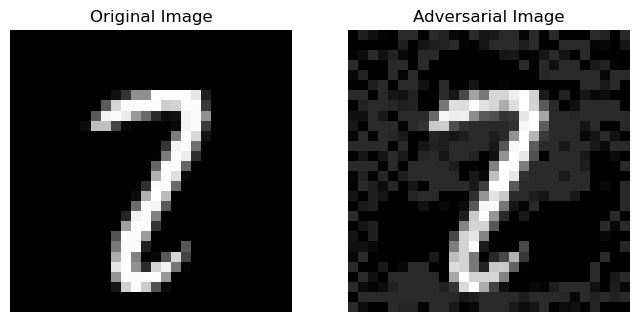

324- Original image (Label: 0), Adversarial image (Label: 4)


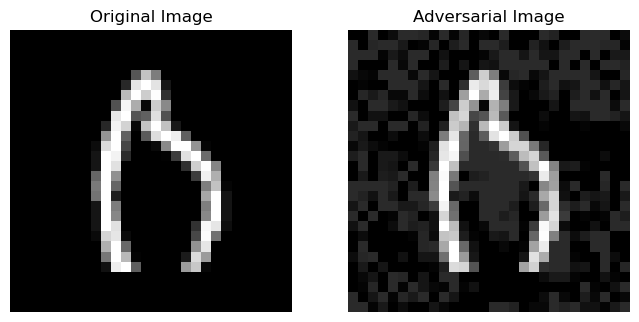

328- Original image (Label: 7), Adversarial image (Label: 8)


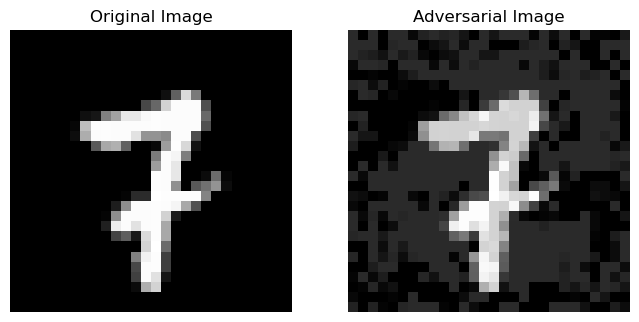

392- Original image (Label: 6), Adversarial image (Label: 9)


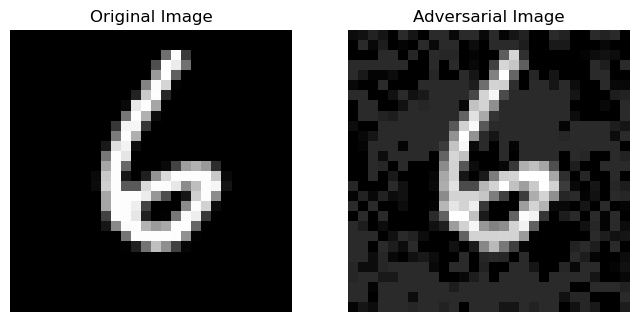

425- Original image (Label: 4), Adversarial image (Label: 6)


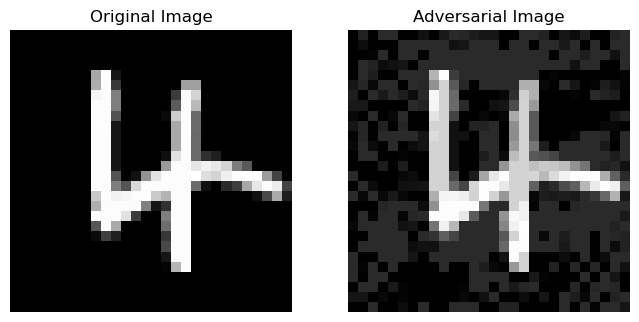

516- Original image (Label: 2), Adversarial image (Label: 4)


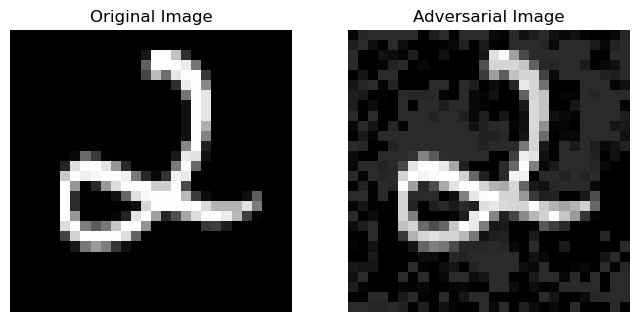

534- Original image (Label: 6), Adversarial image (Label: 2)


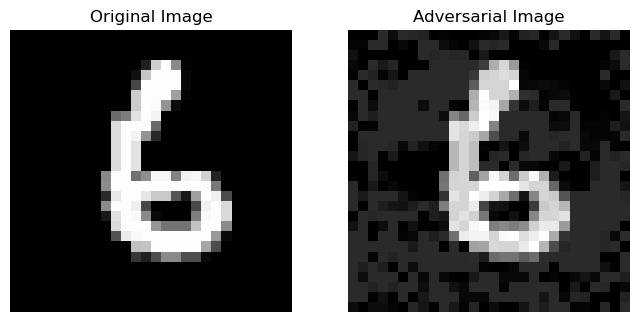

538- Original image (Label: 8), Adversarial image (Label: 6)


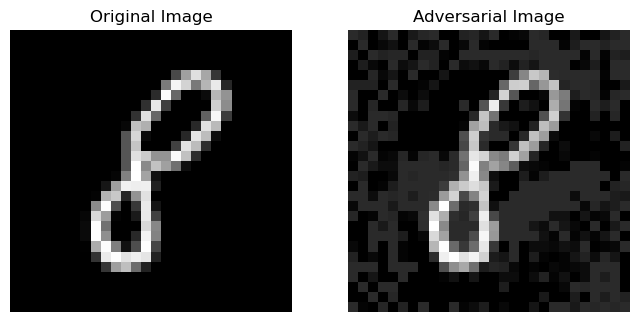

569- Original image (Label: 3), Adversarial image (Label: 4)


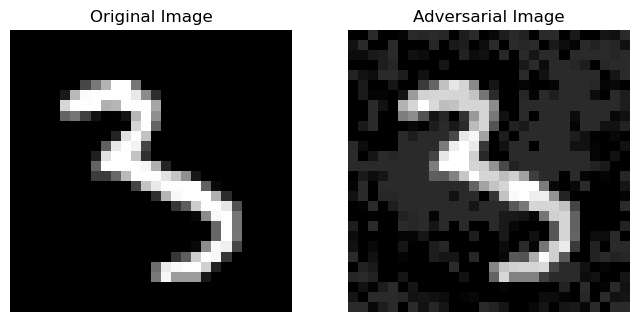

615- Original image (Label: 1), Adversarial image (Label: 2)


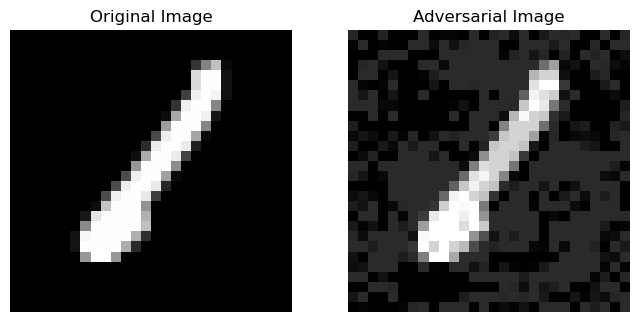

804- Original image (Label: 0), Adversarial image (Label: 9)


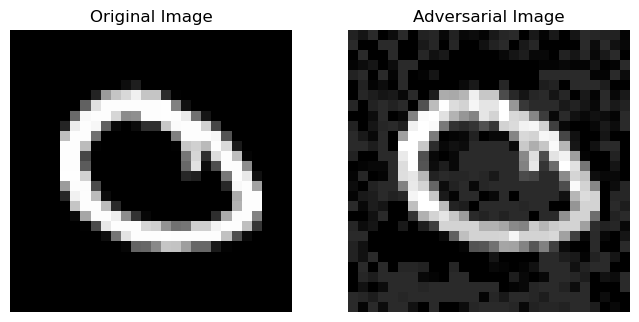

834- Original image (Label: 6), Adversarial image (Label: 1)


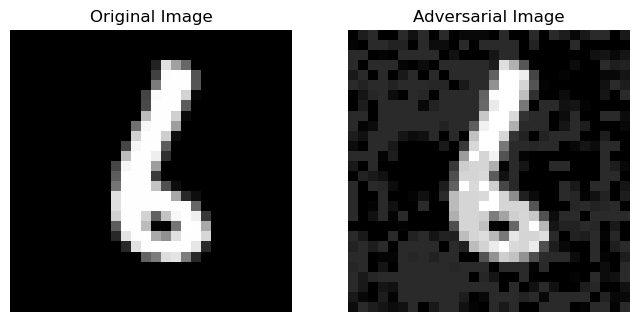

844- Original image (Label: 8), Adversarial image (Label: 7)


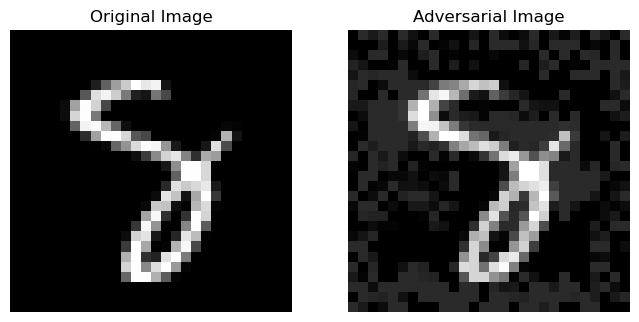

951- Original image (Label: 5), Adversarial image (Label: 4)


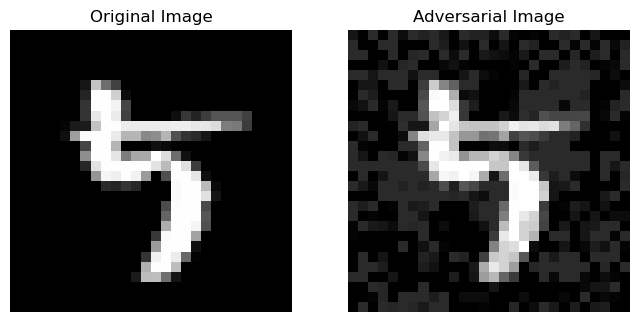

Accuracy on adversarial examples using PGD: 0.007


In [63]:
def evaluate_on_adversarial_pgd(clf, X_test, Y_test, nTest, eps, num_iterations=10):
    clf.set_attack_budget(eps)
    correct = 0
    encountered_labels = set()  # Keep track of encountered label pairs
    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        x_adv = clf.pgd_attack(x, y, num_iterations)  # Perform PGD attack
        y_pred = clf.predict(x_adv)
        if y_pred == y:
            correct += 1

        # Check if the label pair has been encountered before
        label_pair = (y, y_pred)
        if label_pair not in encountered_labels:
            # Print original and adversarial images
            print(f"{i}- Original image (Label: {y}), Adversarial image (Label: {y_pred})")
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(x_adv.reshape(28, 28), cmap='gray')
            plt.title('Adversarial Image')
            plt.axis('off')

            plt.show()

            # Mark the label pair as encountered
            encountered_labels.add(label_pair)

    acc = correct / nTest
    return acc

# Set the number of test examples and epsilon
nTest = len(Y_test)  # Or a smaller number if you want to test on a subset
epsilon = 0.1
num_iterations = 10

# Evaluate the accuracy on adversarial examples using PGD
acc_adv_pgd = evaluate_on_adversarial_pgd(clf, X_test, Y_test, nTest, epsilon, num_iterations)
print(f"Accuracy on adversarial examples using PGD: {acc_adv_pgd}")
